In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [4]:
K = 3
a = 0
b = 1
N = 50
sigma = 1

In [5]:
w_true = np.ones(K)
w_true.shape

(3,)

In [6]:
X = np.linspace(a, b, N)
X.shape

(50,)

In [8]:
def create_vander(K, X):
  N = len(X)
  vander = np.zeros((N, K))
  for i in range(K):
    vander[:,i] = X**i
  return vander

In [9]:
vander = create_vander(K, X)
print(vander.shape)

(50, 3)


In [10]:
def get_y(vander, w_true, sigma):
  e = np.random.normal(0, sigma, N)
  return vander @ w_true + e

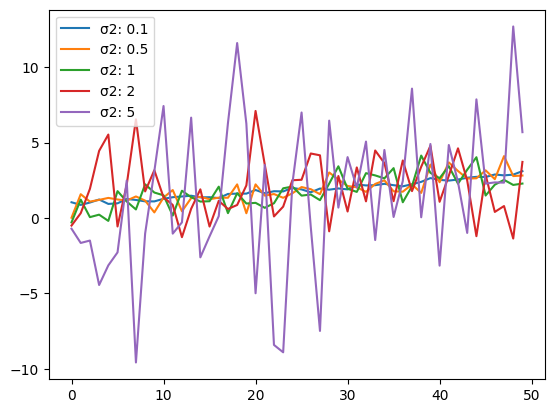

In [11]:
for sigma in [0.1, 0.5, 1, 2, 5]:
  Y = get_y(vander, w_true, sigma)
  plt.plot(range(len(Y)), Y, label=f"σ2: {sigma}")
plt.legend()
plt.show()

In [12]:
def shuffle(X, Y):
    N = len(X)
    idx = np.arange(N)
    np.random.shuffle(idx)

    new_X = X[idx]
    new_Y = Y[idx]

    return new_X, new_Y

In [13]:
Y = get_y(vander, w_true.T, 0.1)
split_ratio = 0.7
split = int(len(X)*split_ratio)

X, Y = shuffle(X, Y)
X_train = X[:split]
y_train = Y[:split]
X_test = X[split:]
y_test = Y[split:]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35,) (35,) (15,) (15,)


In [14]:
def grad_loss_mle(X, y, w, lam=None):
  vander = create_vander(len(w), X)
  return vander.T @ ((vander @ w) - y)

def grad_loss_map(X, y, w, lam=2):
  vander = create_vander(len(w), X)
  return vander.T @ ((vander @ w) - y) + 2 * lam * w

print(grad_loss_mle(X_train, y_train, np.array([2,2,2])))
print(grad_loss_map(X_train, y_train, np.array([2,2,2]), 1))

[65.20332139 39.29928022 29.4891077 ]
[69.20332139 43.29928022 33.4891077 ]


In [15]:
def normal_eq_mle(vander, Y):
    first_fact = vander.T @ vander
    second_fact = vander.T @ Y
    try:
      L = scipy.linalg.cholesky(first_fact, lower = True)
      y = scipy.linalg.solve_triangular(L, b, lower = True)
      w = scipy.linalg.solve_triangular(L.T, y)
    except:
      w = np.linalg.solve(first_fact, second_fact)
    return w

In [16]:
def normal_eq_map(vander, Y, lam):
    first_fact = vander.T @ vander + (lam * np.eye(vander.shape[1]))
    second_fact = vander.T @ Y
    try:
      L = scipy.linalg.cholesky(first_fact, lower = True)
      y = scipy.linalg.solve_triangular(L, b, lower = True)
      w = scipy.linalg.solve_triangular(L.T, y)
    except:
      w = np.linalg.solve(first_fact, second_fact)
    return w

In [17]:
def GD(x0, D, grad_f, tolf=1e-6, tolx=1e-6, kmax=1000000, alpha=1e-5, lam=1):
    k=0
    (X, Y) = D
    xk = x0

    xs = [xk]
    grad_vals = [grad_f(X, Y, xk, lam)]

    while (np.linalg.norm(grad_f(X, Y, xk, lam)) >= tolf and k < kmax - 1):
        x_prec = xk
        xk = x_prec - (alpha * grad_f(X, Y, x_prec, lam))

        xs.append(xk)
        grad_vals.append(grad_f(X, Y, xk, lam))

        if np.linalg.norm(grad_vals[-1]) < tolf:
            break

        if np.linalg.norm(xk - xs[-1]) < tolx:
            break

        k+=1

    return xk

In [18]:
def SGD(w0, D, grad_f, batch_size = 5, n_epochs = 10, alpha = 1e-5, lam=1):
    (X, Y) = D
    N = len(X)

    n_batch_per_epoch = N//batch_size

    w = np.array(w0)
    ws = [w]

    for epoch in range(n_epochs):
        X_new, Y_new = shuffle(X, Y)

        for batch in range(n_batch_per_epoch):
            n = batch * batch_size
            m = (batch+1) * batch_size
            Mx = X_new[n:m]
            My = Y_new[n:m]

            w = w - (alpha * grad_f(Mx, My, w, lam))
            ws.append(w)

    return w

In [19]:
def mle(D, K, solver="SGD"):
  X, y = D
  w = None
  if solver=="SGD":
    w0 = np.random.normal(1, 0.1, K)
    w = SGD(w0, D, grad_loss_mle)
  elif solver=="GD":
    w0 = np.random.normal(1, 0.1, K)
    w = GD(w0, D, grad_loss_mle)
  elif solver=="NE":
    vander = create_vander(K, X)
    w = normal_eq_mle(vander, y)
  return w

print(mle((X_train, y_train), K))
print(mle((X_train, y_train), K, "GD"))
print(mle((X_train, y_train), K, "NE"))

[1.04932371 0.98860139 0.88048676]
[1.06703168 1.21765866 0.97961865]
[0.99595794 0.7946195  1.27834047]


In [20]:
def map_f(D, K, lam=1, solver="SGD"):
  X, y = D
  w = None
  if solver=="SGD":
    w0 = np.random.normal(1, 0.1, K)
    w = SGD(w0, D, grad_loss_map, lam=lam)
  elif solver=="GD":
    w0 = np.random.normal(1, 0.1, K)
    w = GD(w0, D, grad_loss_map, lam=lam)
  elif solver=="NE":
    vander = create_vander(K, X)
    w = normal_eq_map(vander, y, lam)
  return w

print(map_f((X_train, y_train), K))
print(map_f((X_train, y_train), K, solver="GD"))
print(map_f((X_train, y_train), K, solver="NE"))

[1.04927723 0.89500138 1.10274819]
[0.9229553  0.88803951 0.94533278]
[0.98645898 0.99599596 0.93382379]


In [21]:
def get_error(D, w):
  X, y_true = D
  vander = create_vander(len(w), X)
  y = vander @ w
  return (np.linalg.norm(y - y_true)**2)/len(X)

############################

     MLE, N=50

############################



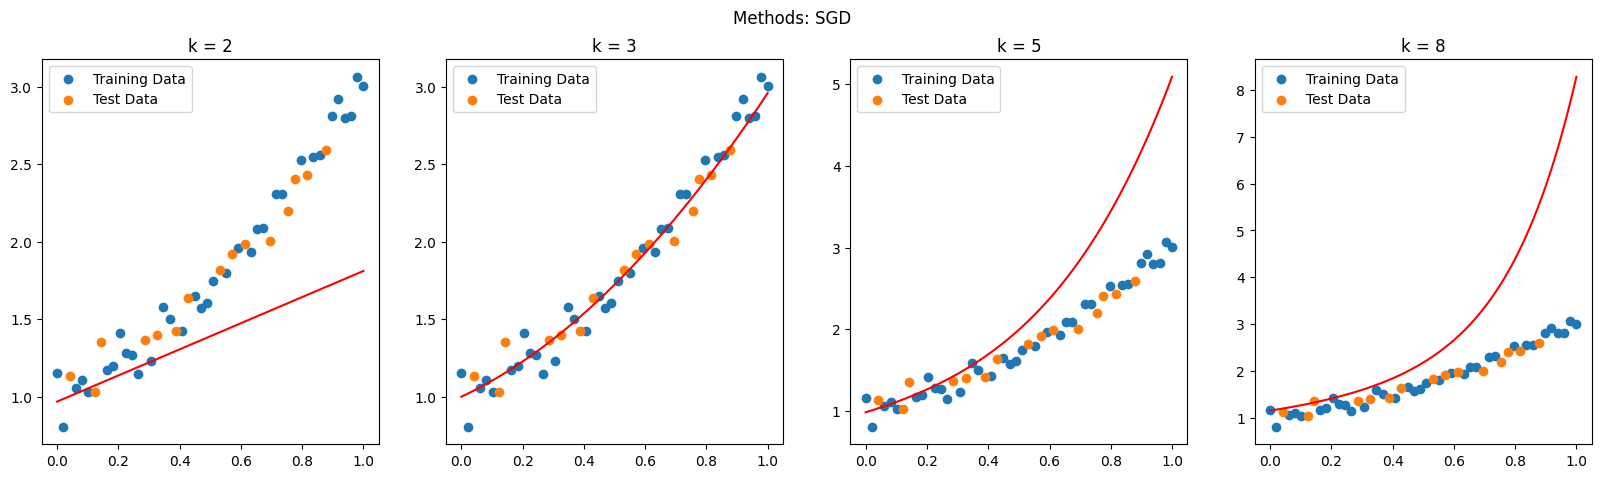

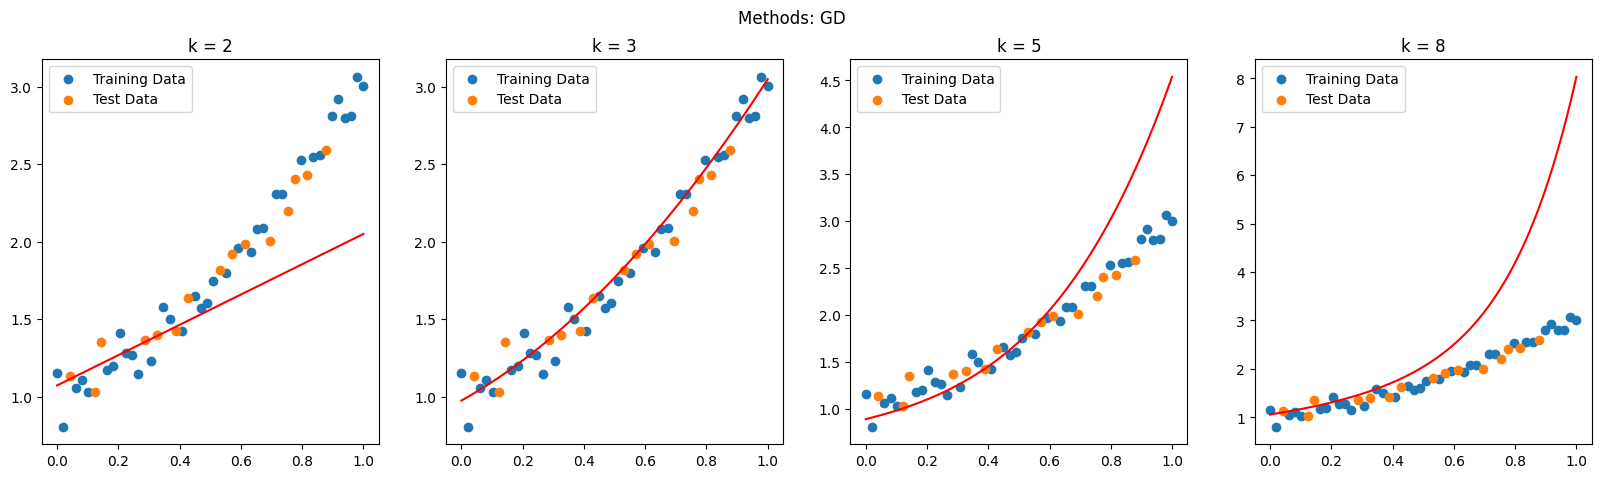

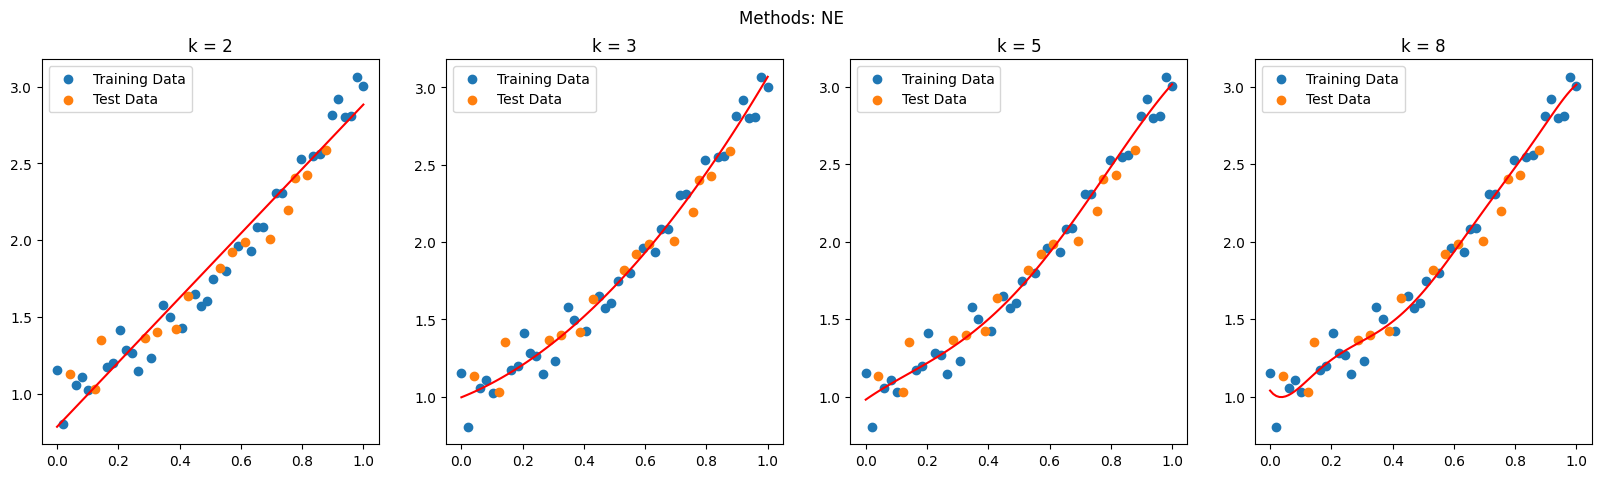

In [22]:
err_train_mle = {"SGD":[],"GD":[],"NE":[]}
err_test_mle = {"SGD":[],"GD":[],"NE":[]}
params = {"SGD":[],"GD":[],"NE":[]}
ks = [2, 3, 5, 8]
methods = ["SGD", "GD","NE"]

print("############################", end='\n\n')
print(f"     MLE, N={N}", end='\n\n')
print("############################", end='\n\n')

for method in methods:
  for k in ks:
    params[method].append(mle((X_train, y_train), k, solver=method))
    err_train_mle[method].append(get_error((X_train, y_train), params[method][-1]))
    err_test_mle[method].append(get_error((X_test, y_test), params[method][-1]))

for method in methods:
  plt.figure(figsize = (20, 5))
  plt.suptitle(f"Methods: " + method)
  for i,k in enumerate(ks):
    x_f = np.linspace(a, b, 100)
    vander = create_vander(len(params[method][i]), x_f)
    y_f = vander @ params[method][i]

    plt.subplot(1, len(ks), i+1)
    plt.plot(x_f, y_f, color="red")
    plt.scatter(X_train, y_train, label="Training Data")
    plt.scatter(X_test, y_test, label = "Test Data")
    plt.title(f"k = {k}")
    plt.legend()


############################

     MLE, N=50

############################



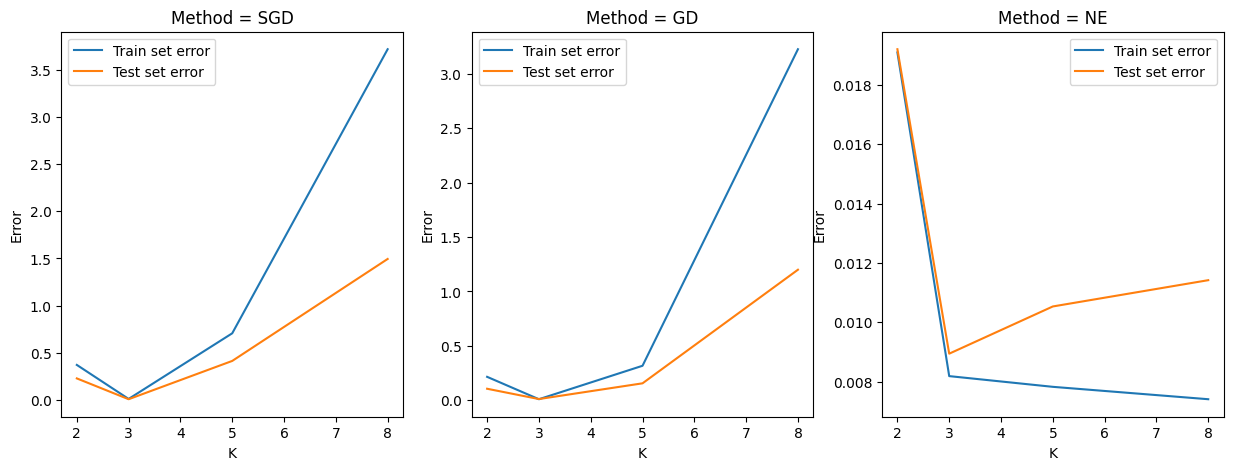

In [23]:
print("############################", end='\n\n')
print(f"     MLE, N={N}", end='\n\n')
print("############################", end='\n\n')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i,method in enumerate(methods):
  ax[i].plot(ks, err_train_mle[method], label = "Train set error")
  ax[i].plot(ks, err_test_mle[method], label = "Test set error")
  ax[i].set_title(f"Method = {method}")
  ax[i].legend()
  ax[i].set_xlabel("K")
  ax[i].set_ylabel("Error")

In [ ]:
def calculate_error_w(w, w_true):
    padded_w_true = np.pad(w_true, (0, len(w) - len(w_true)), 'constant')
    error = np.linalg.norm(w - padded_w_true)**2 / np.linalg.norm(padded_w_true)**2
    return error

############################

     MAP, N=50

############################



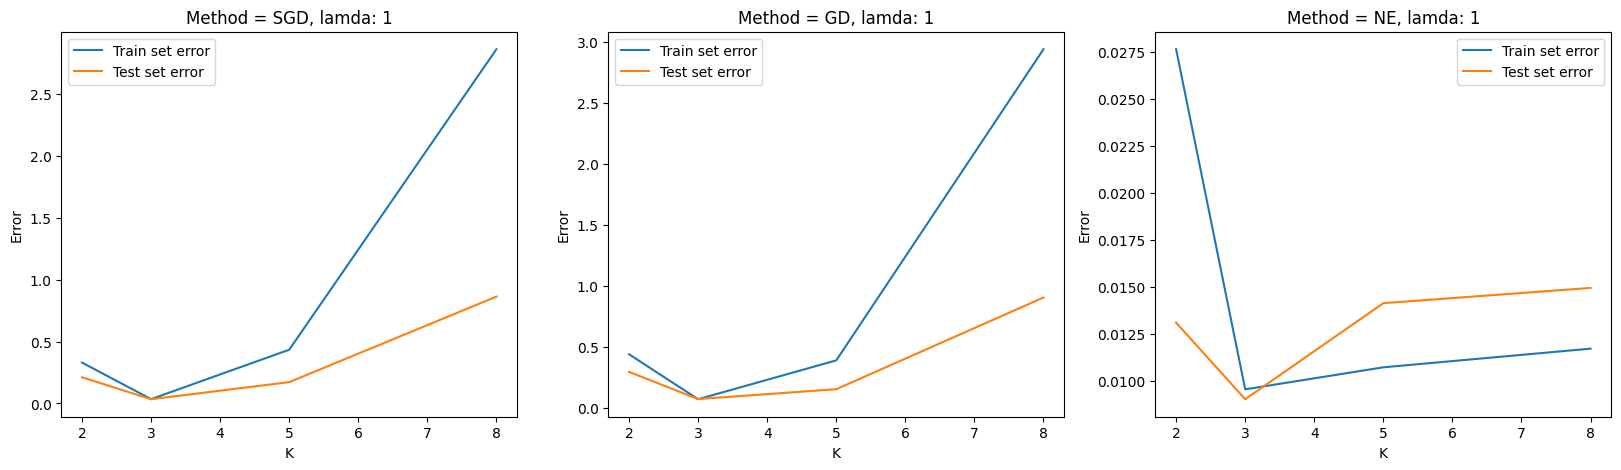

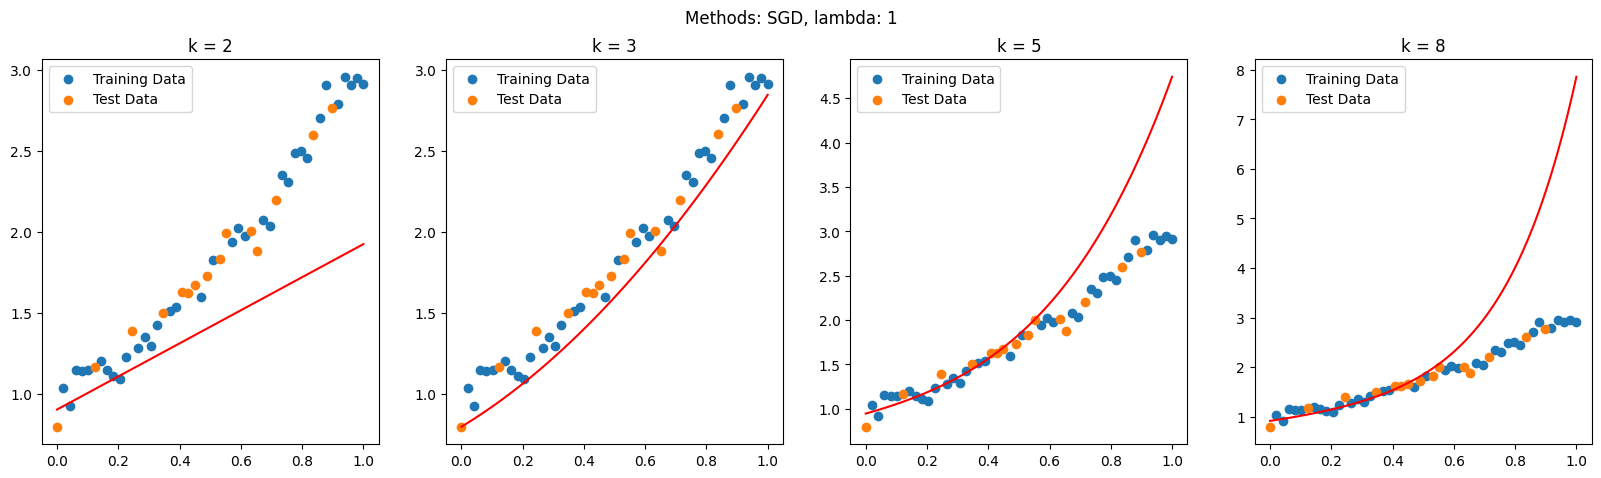

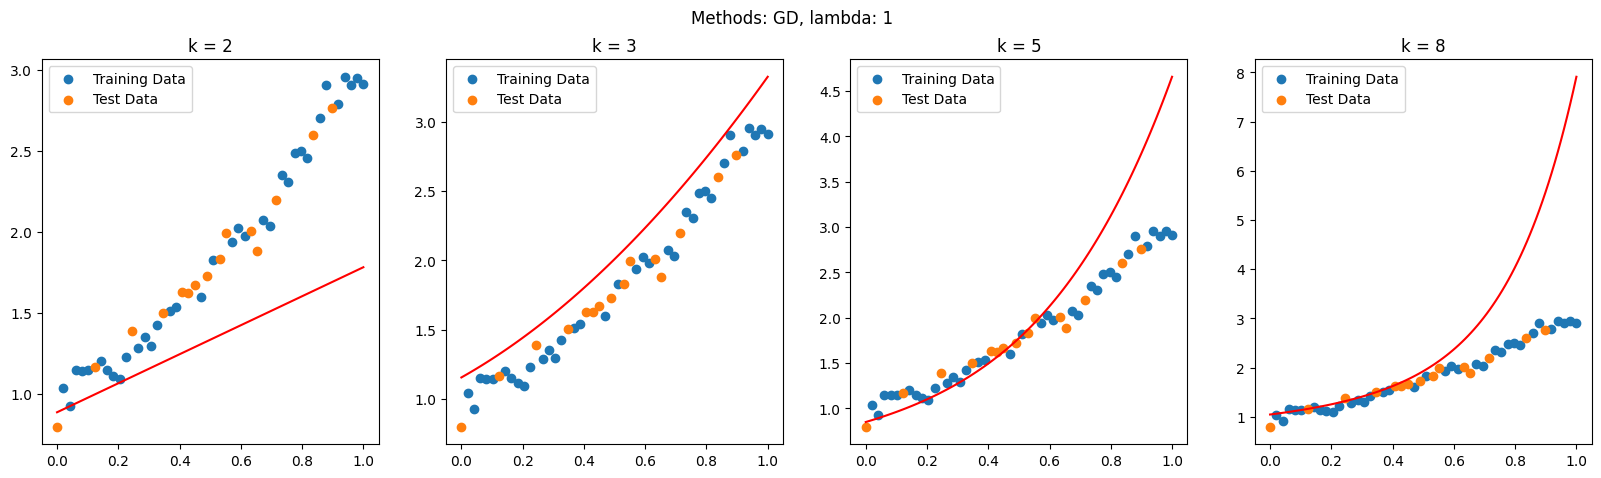

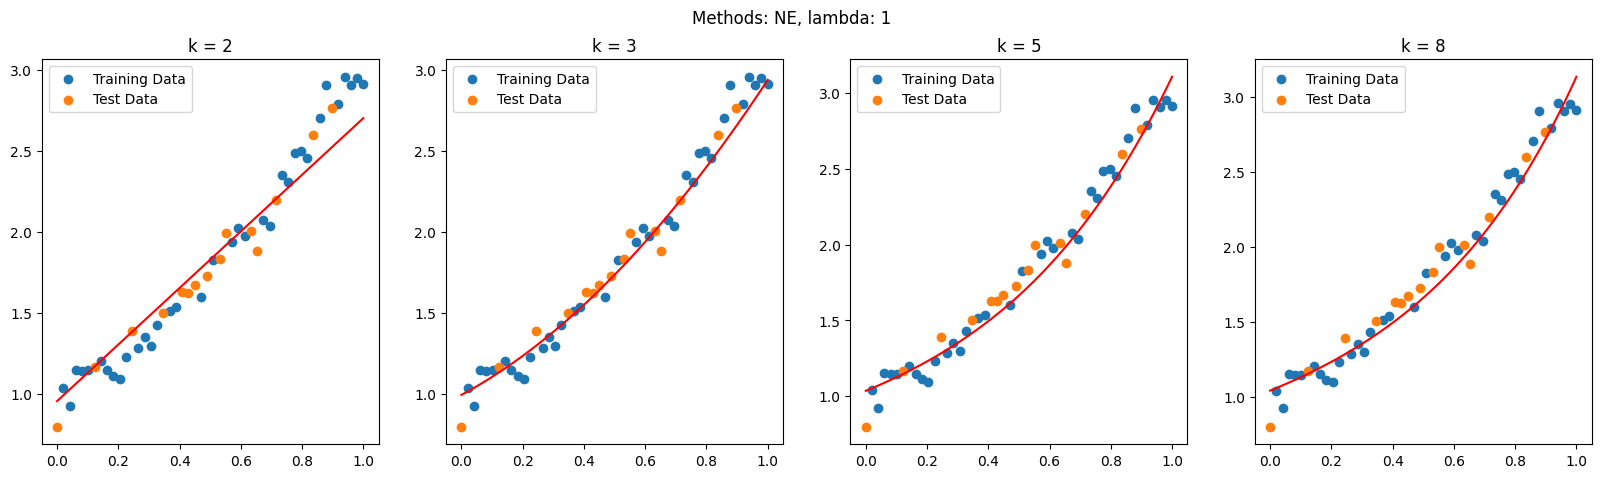

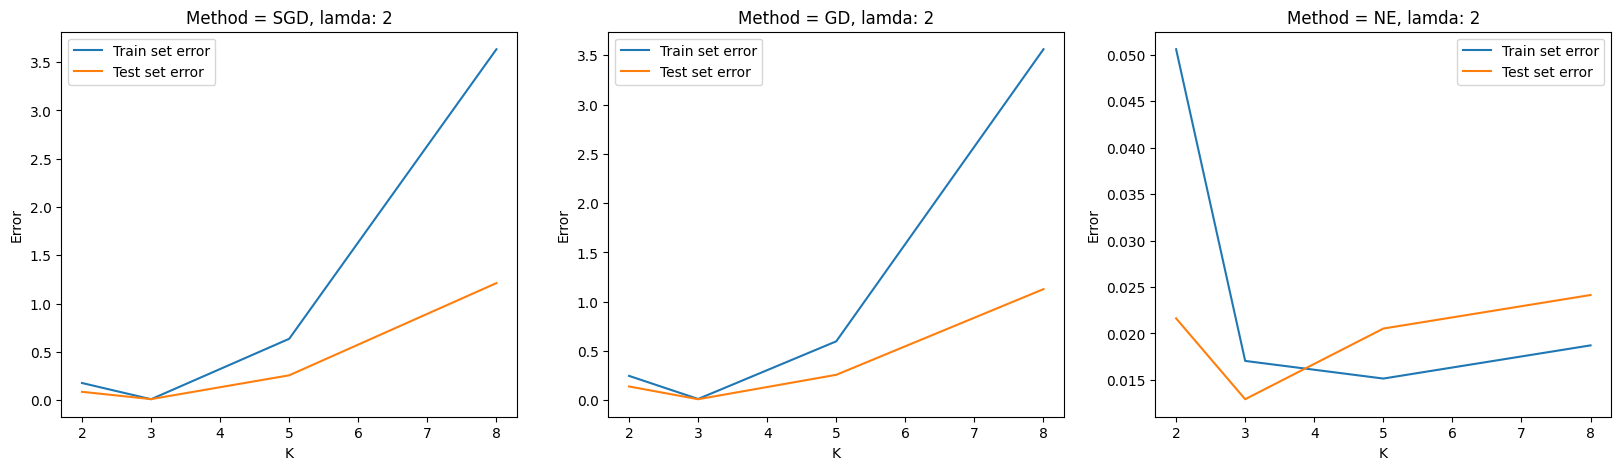

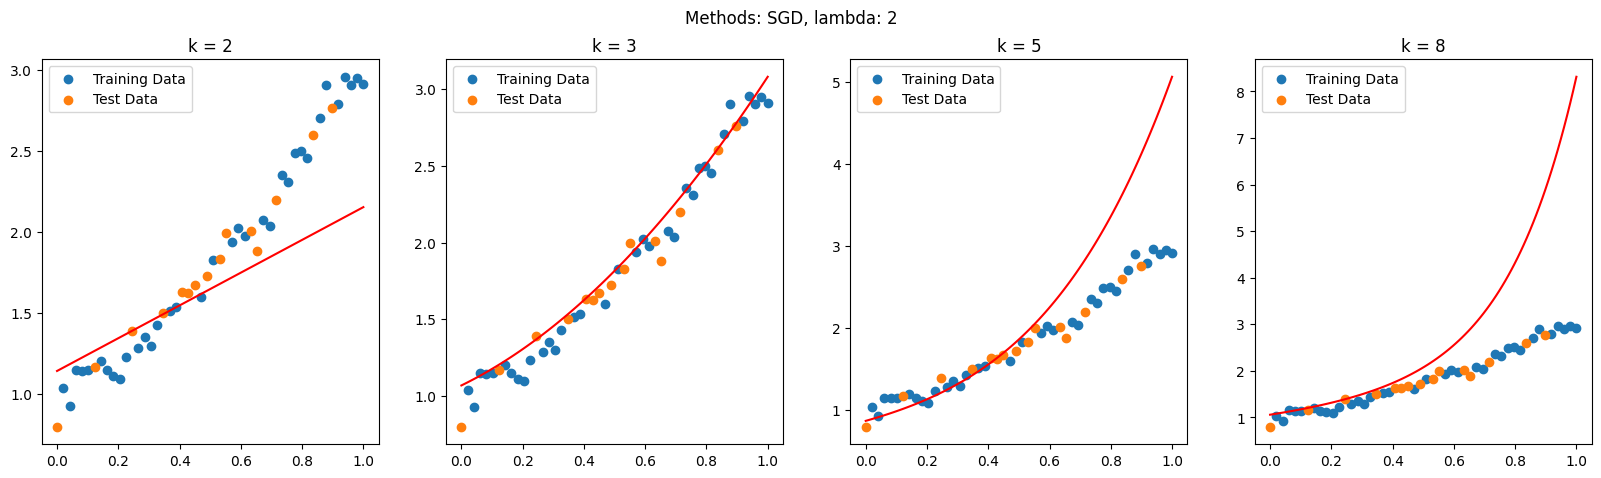

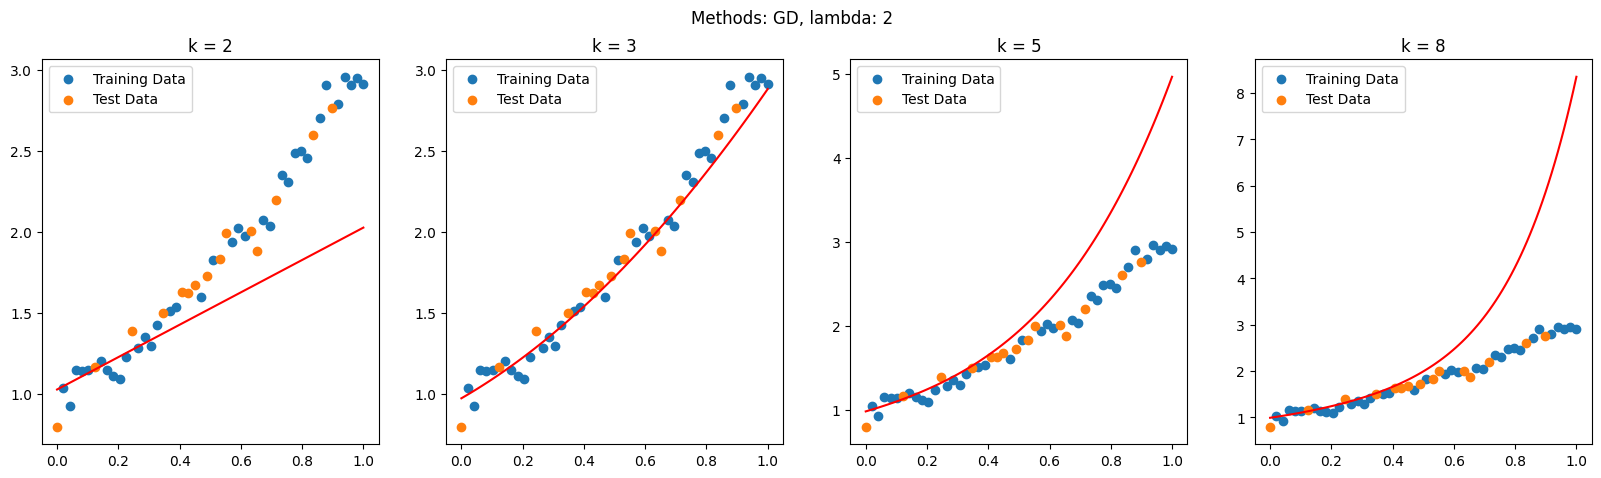

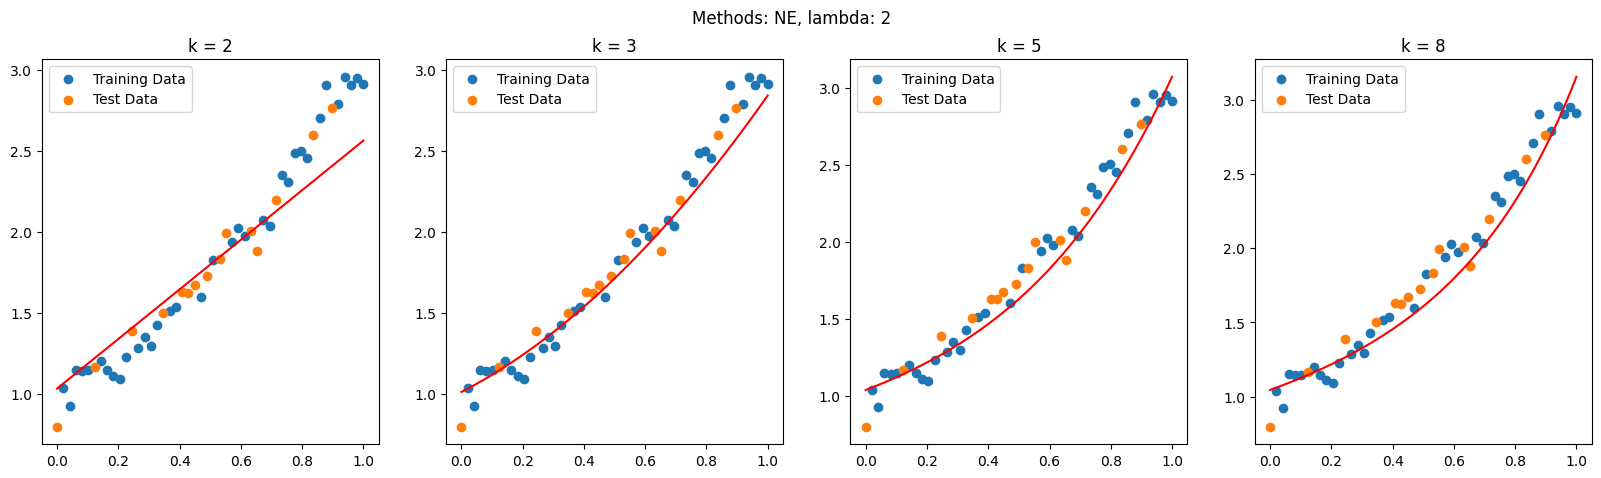

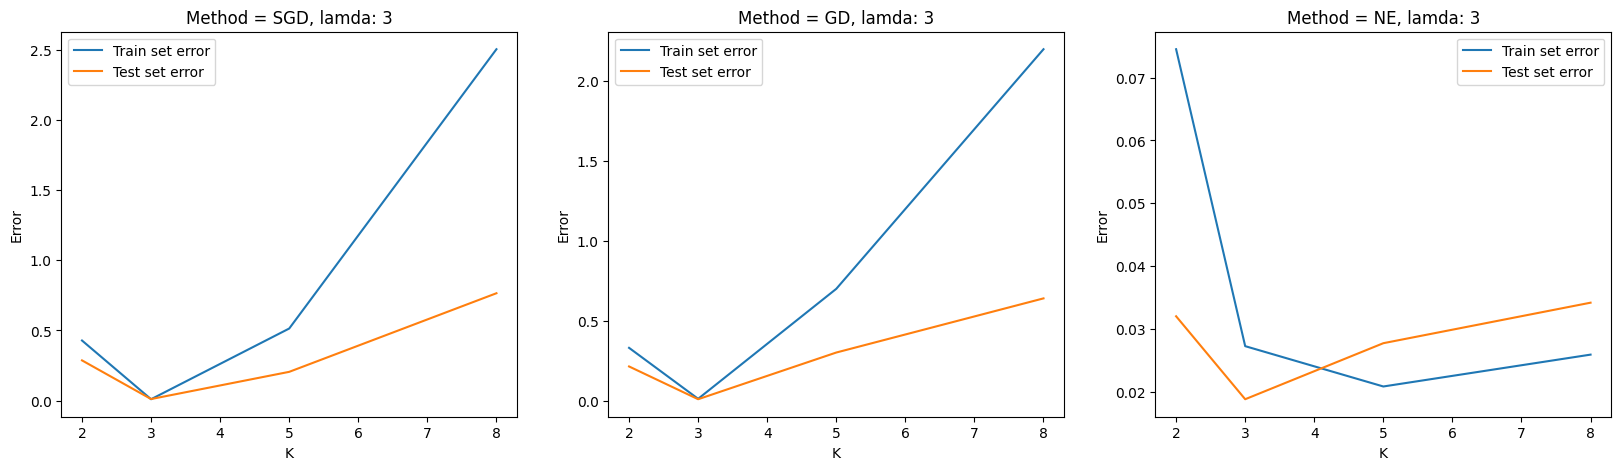

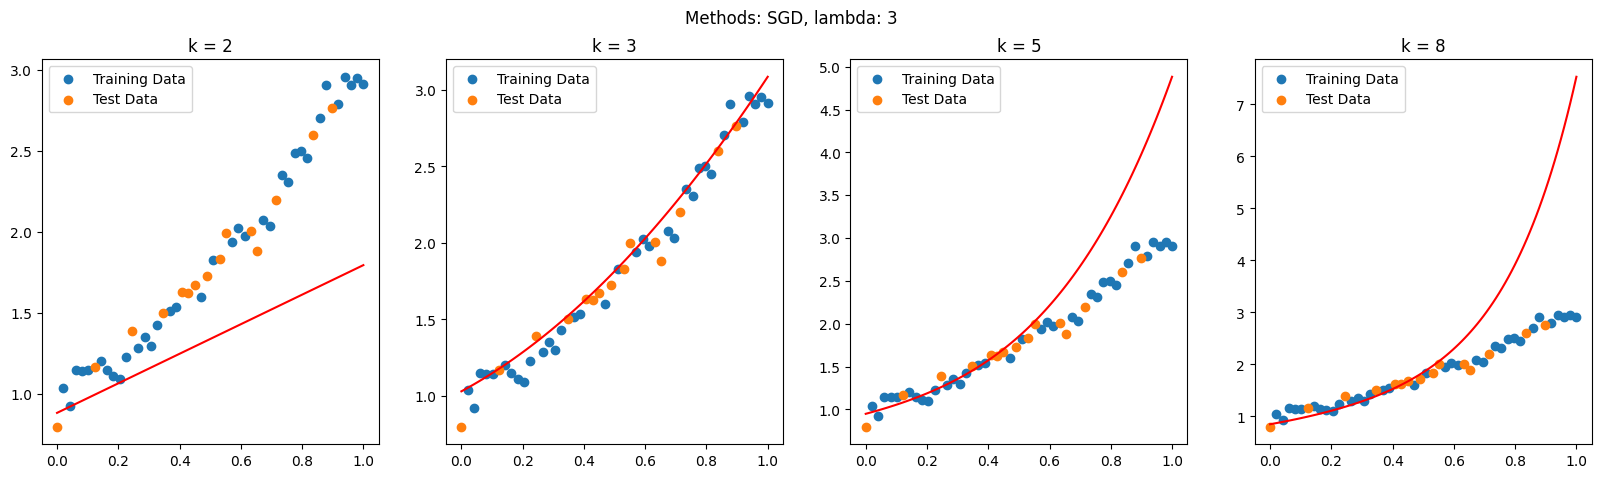

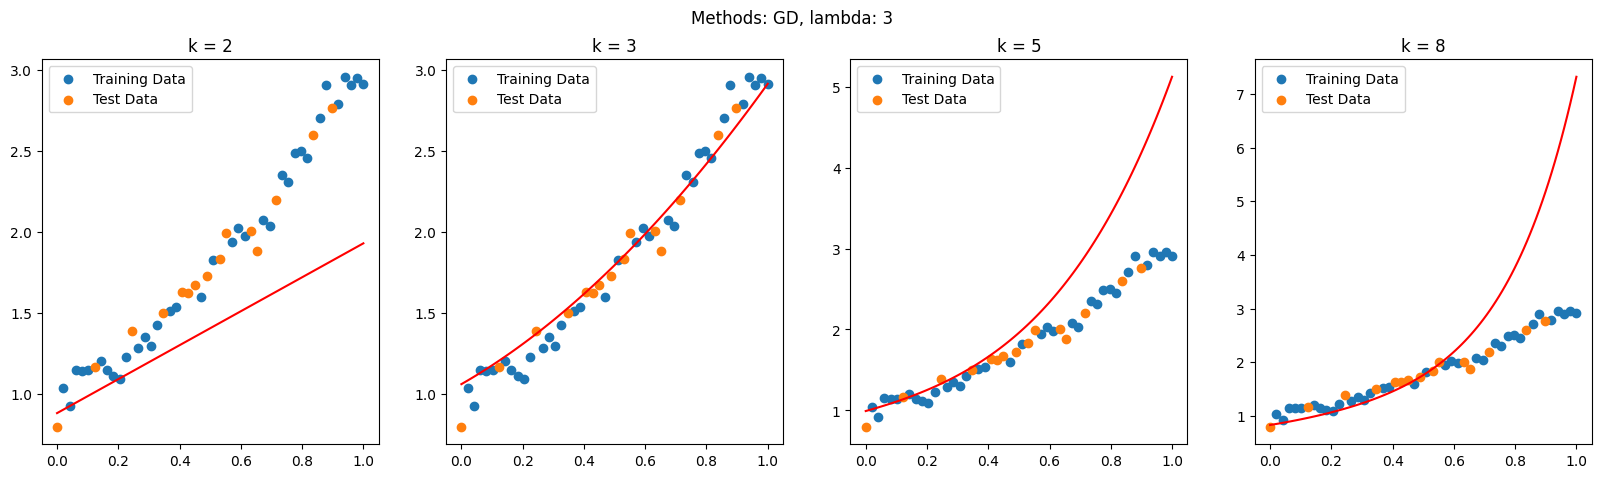

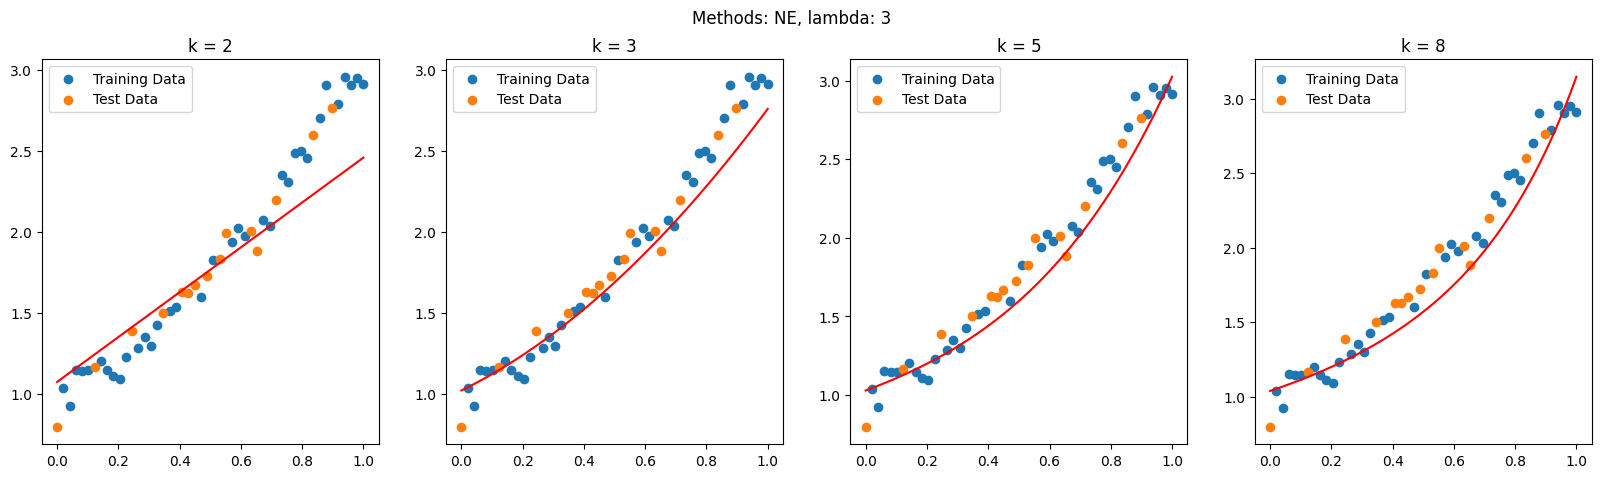

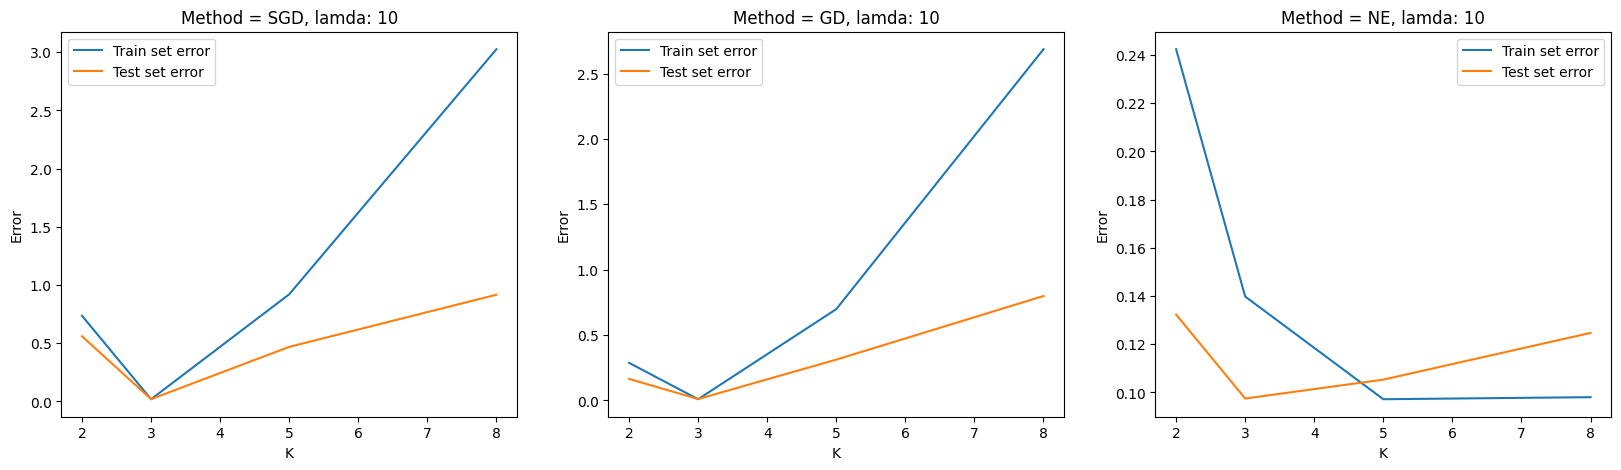

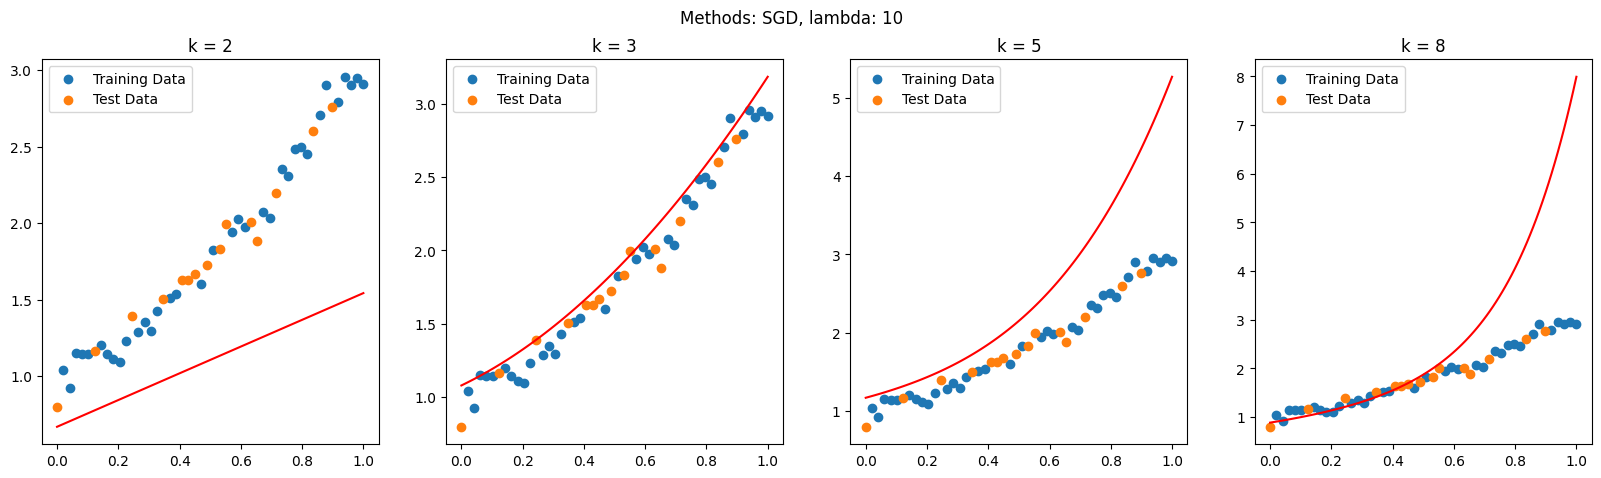

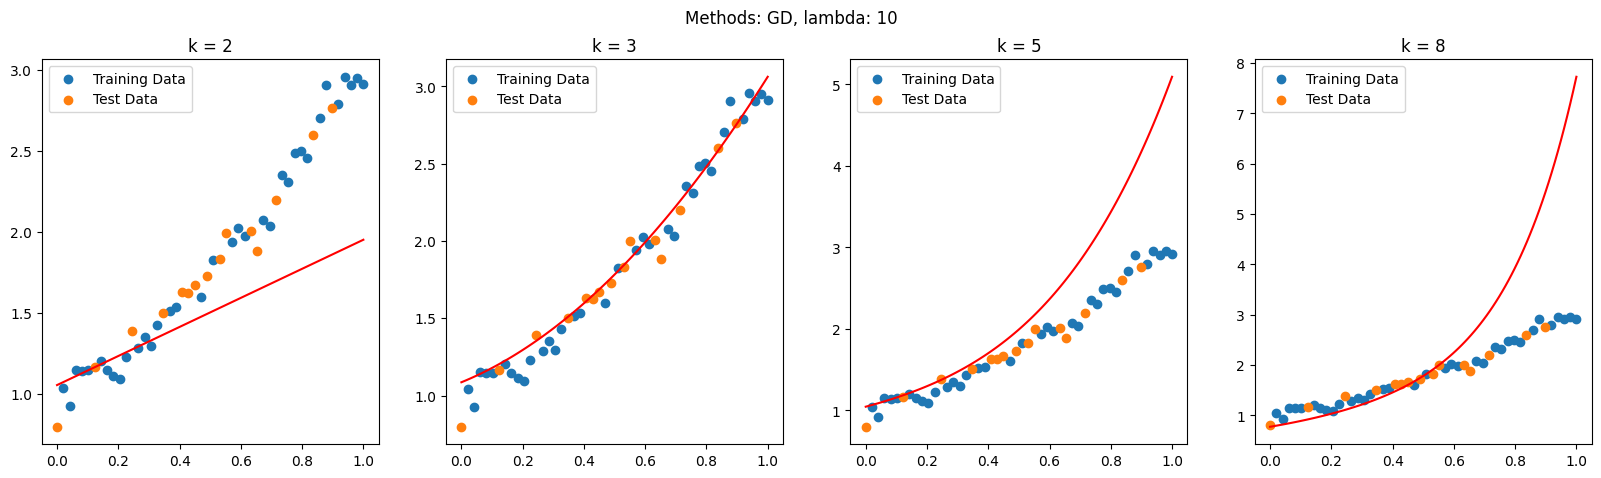

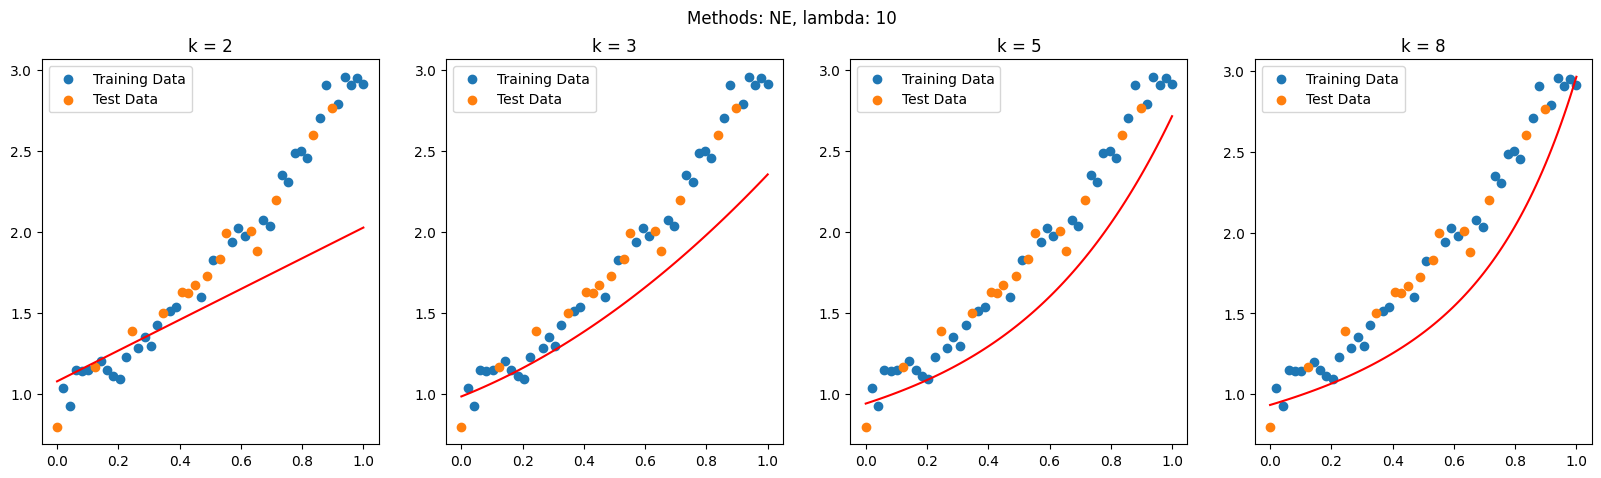

In [ ]:
ks = [2, 3, 5, 8]
methods = ["SGD", "GD","NE"]
lambs = [1, 2, 3, 10]

print("############################", end='\n\n')
print(f"     MAP, N={N}", end='\n\n')
print("############################", end='\n\n')

for lam in lambs:
  err_train_mle = {"SGD":[],"GD":[],"NE":[]}
  err_test_mle = {"SGD":[],"GD":[],"NE":[]}
  params = {"SGD":[],"GD":[],"NE":[]}
  plt.figure(figsize = (20, 5))
  for i, method in enumerate(methods):
    for k in ks:
      last_w = map_f((X_train, y_train), k, lam=lam, solver=method)
      params[method].append(last_w)
      err_train_mle[method].append(get_error((X_train, y_train), last_w))
      err_test_mle[method].append(get_error((X_test, y_test), last_w))

    plt.subplot(1, len(methods), i+1)
    plt.plot(ks, err_train_mle[method], label = "Train set error")
    plt.plot(ks, err_test_mle[method], label = "Test set error")
    plt.title(f"Method = {method}, lamda: {lam}")
    plt.xlabel("K")
    plt.ylabel("Error")
    plt.legend()

  for method in methods:
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"Methods: {method}, lambda: {lam}")
    for i,k in enumerate(ks):
      x_f = np.linspace(a, b, 100)
      vander = create_vander(len(params[method][i]), x_f)
      y_f = vander @ params[method][i]

      plt.subplot(1, len(ks), i+1)
      plt.plot(x_f, y_f, color="red")
      plt.scatter(X_train, y_train, label="Training Data")
      plt.scatter(X_test, y_test, label = "Test Data")
      plt.title(f"k = {k}")
      plt.legend()

############################

     MLE, N=500

############################



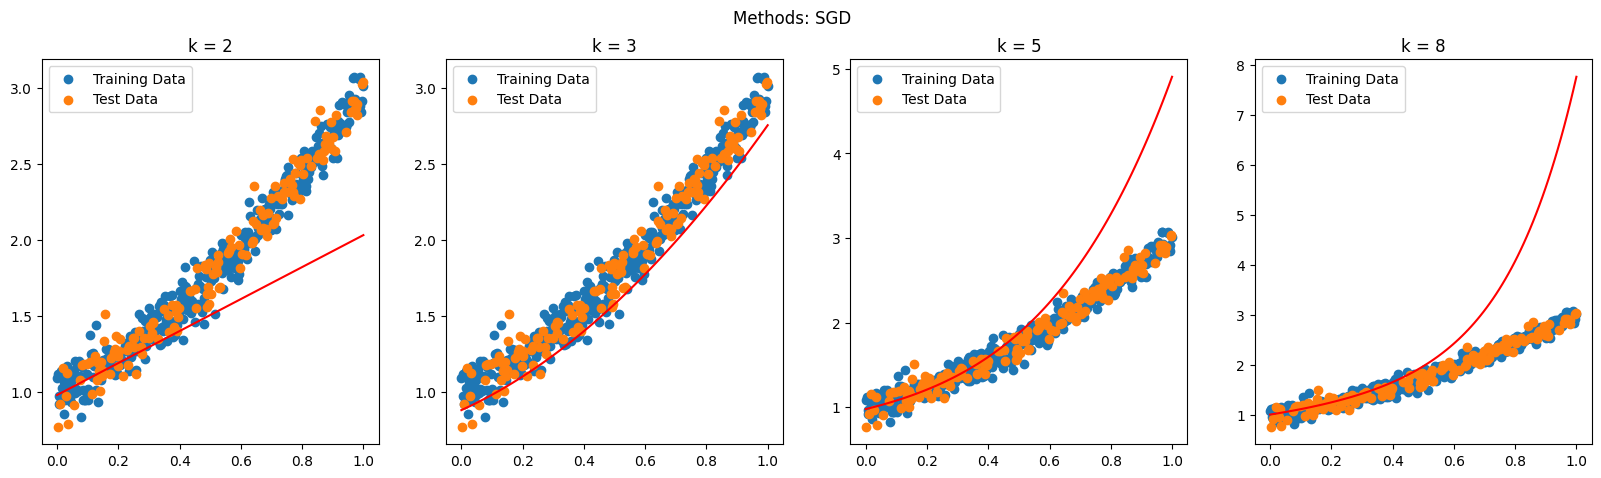

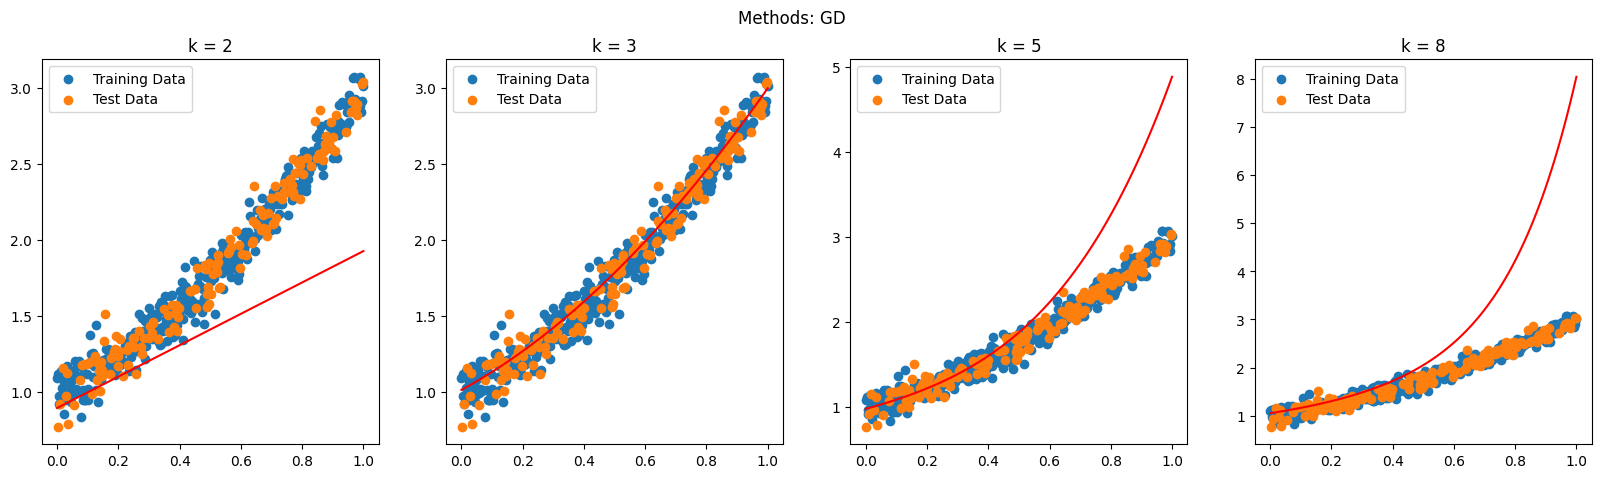

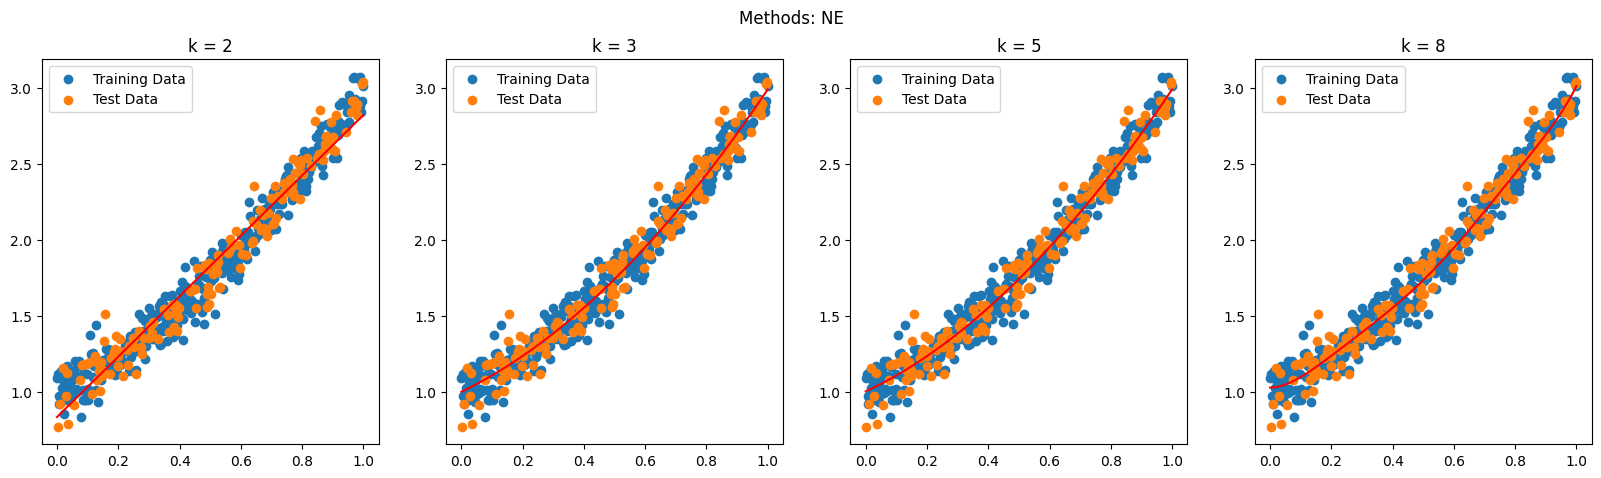

In [ ]:
err_train_mle = {"SGD":[],"GD":[],"NE":[]}
err_test_mle = {"SGD":[],"GD":[],"NE":[]}
params = {"SGD":[],"GD":[],"NE":[]}
ks = [2, 3, 5, 8]
methods = ["SGD", "GD","NE"]

print("############################", end='\n\n')
print(f"     MLE, N={N}", end='\n\n')
print("############################", end='\n\n')

for method in methods:
  for k in ks:
    params[method].append(mle((X_train, y_train), k, solver=method))
    err_train_mle[method].append(get_error((X_train, y_train), params[method][-1]))
    err_test_mle[method].append(get_error((X_test, y_test), params[method][-1]))

for method in methods:
  plt.figure(figsize = (20, 5))
  plt.suptitle(f"Methods: " + method)
  for i,k in enumerate(ks):
    x_f = np.linspace(a, b, 100)
    vander = create_vander(len(params[method][i]), x_f)
    y_f = vander @ params[method][i]

    plt.subplot(1, len(ks), i+1)
    plt.plot(x_f, y_f, color="red")
    plt.scatter(X_train, y_train, label="Training Data")
    plt.scatter(X_test, y_test, label = "Test Data")
    plt.title(f"k = {k}")
    plt.legend()

############################

     MLE, N=500

############################



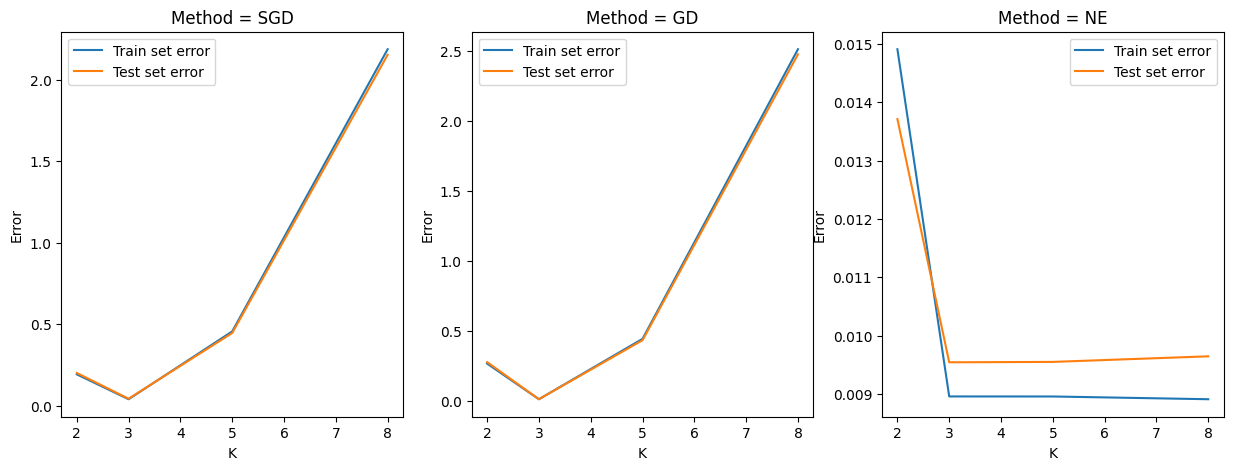

In [ ]:
print("############################", end='\n\n')
print(f"     MLE, N={N}", end='\n\n')
print("############################", end='\n\n')

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i,method in enumerate(methods):
  ax[i].plot(ks, err_train_mle[method], label = "Train set error")
  ax[i].plot(ks, err_test_mle[method], label = "Test set error")
  ax[i].set_title(f"Method = {method}")
  ax[i].legend()
  ax[i].set_xlabel("K")
  ax[i].set_ylabel("Error")

############################

     MAP, N=500

############################



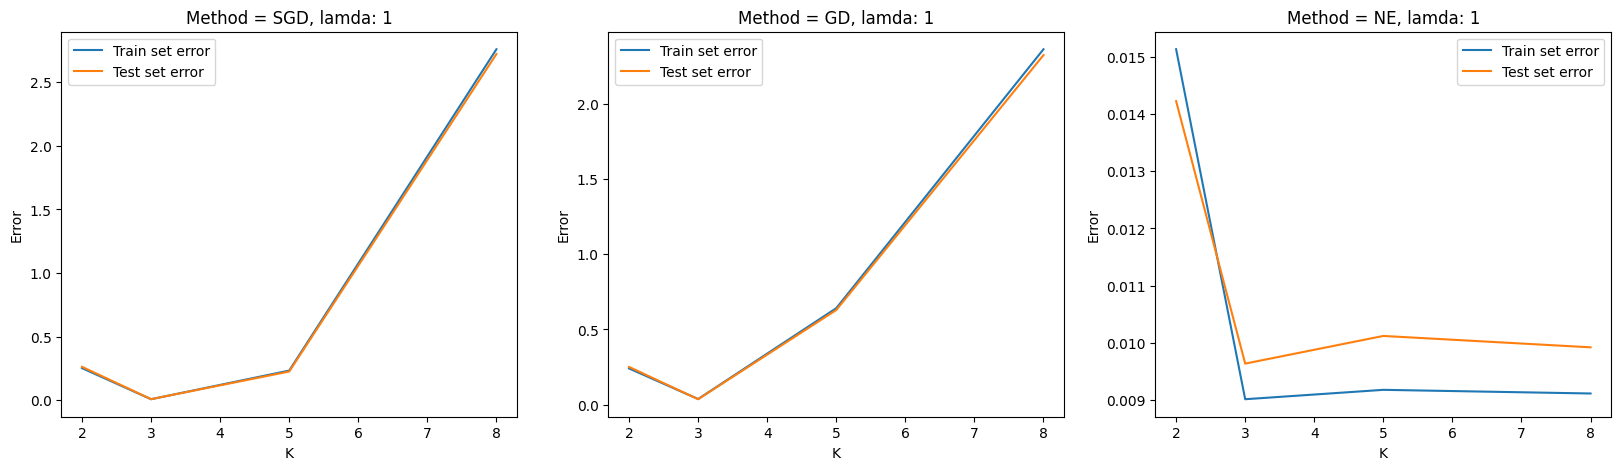

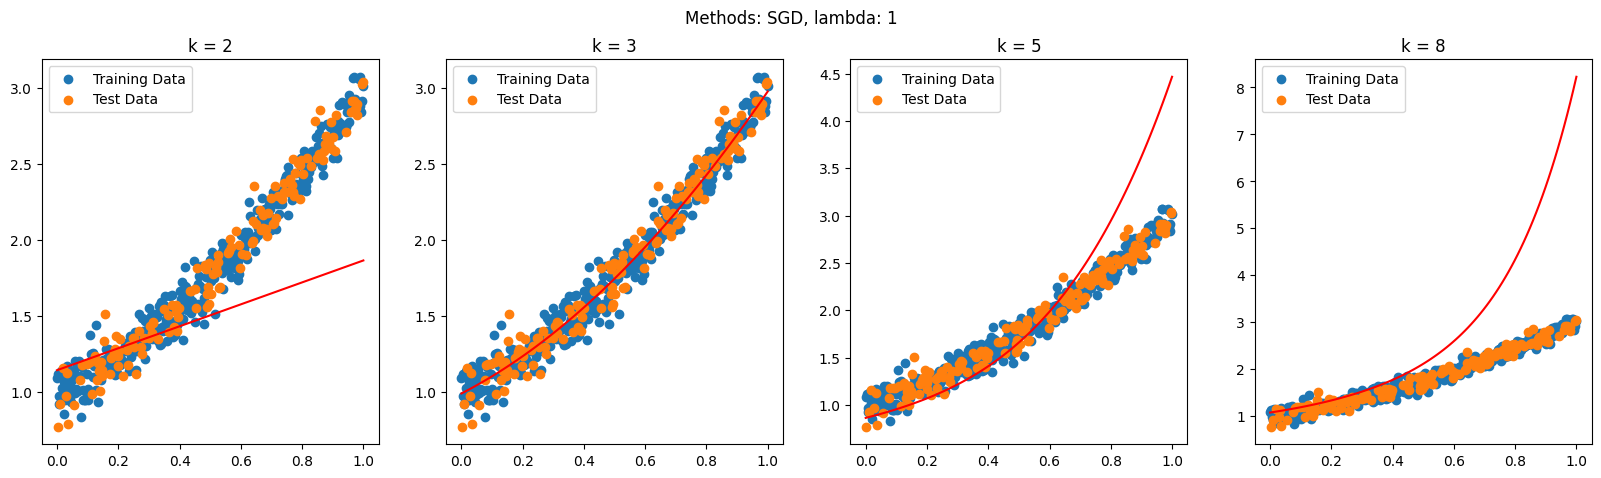

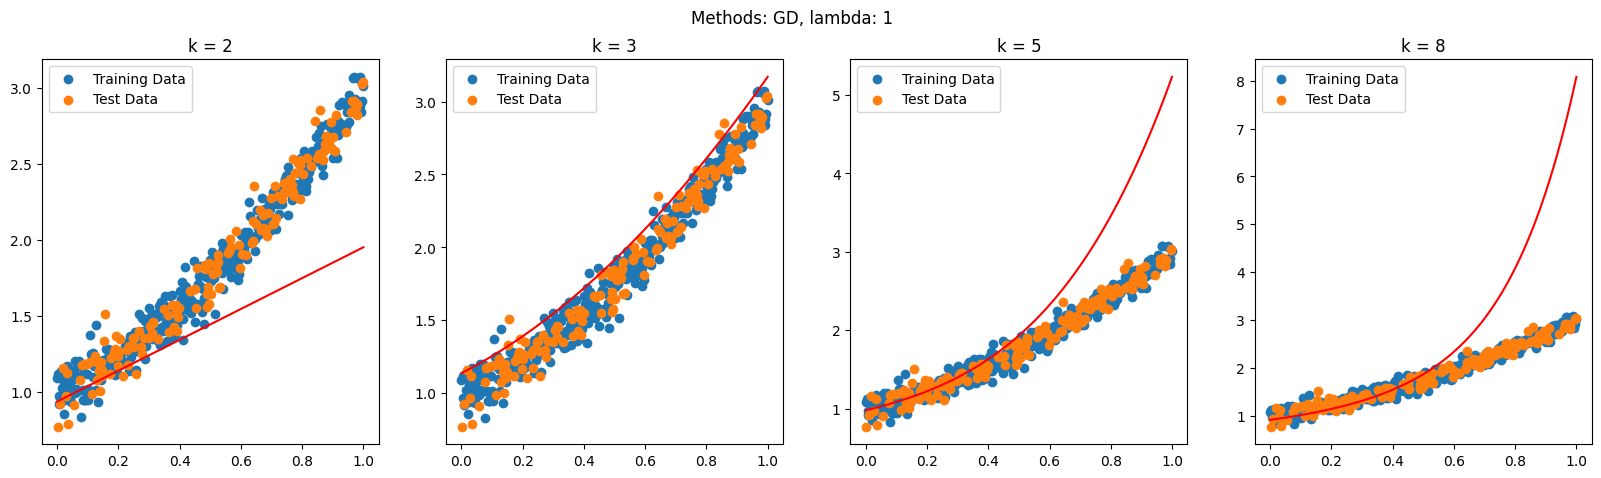

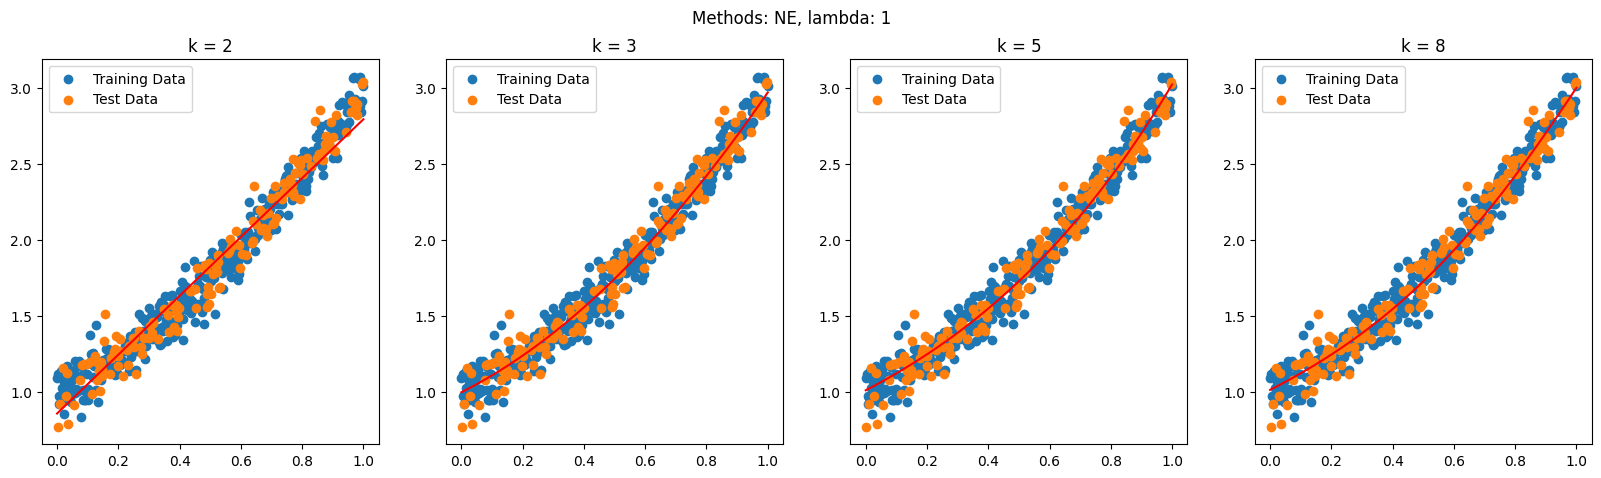

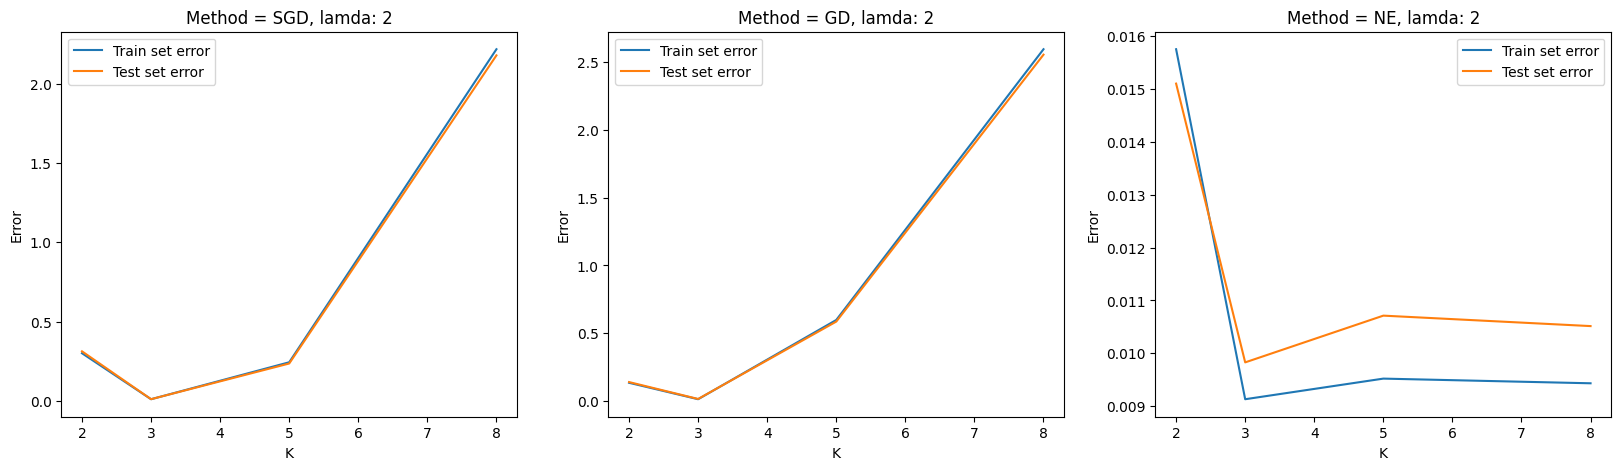

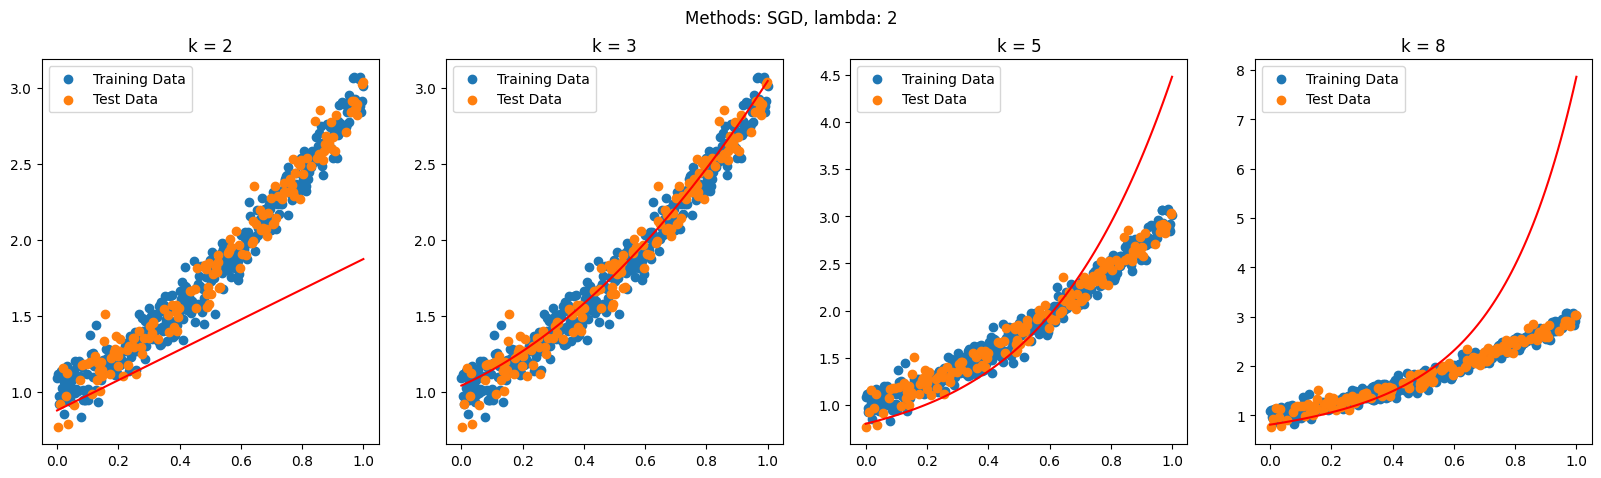

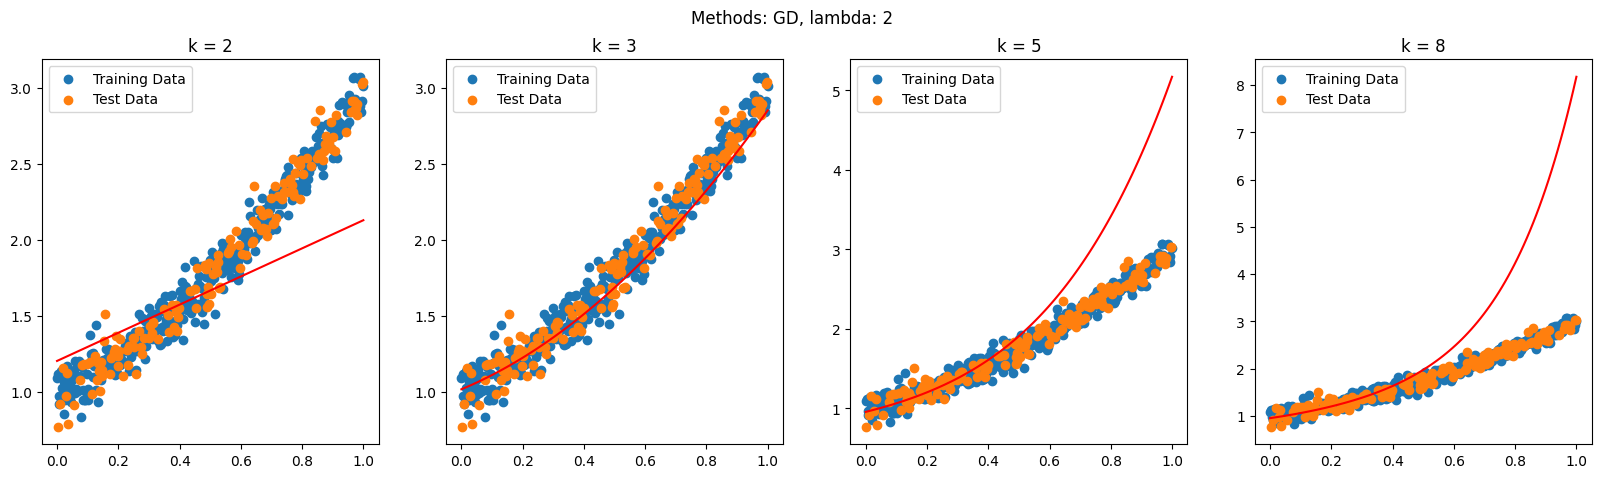

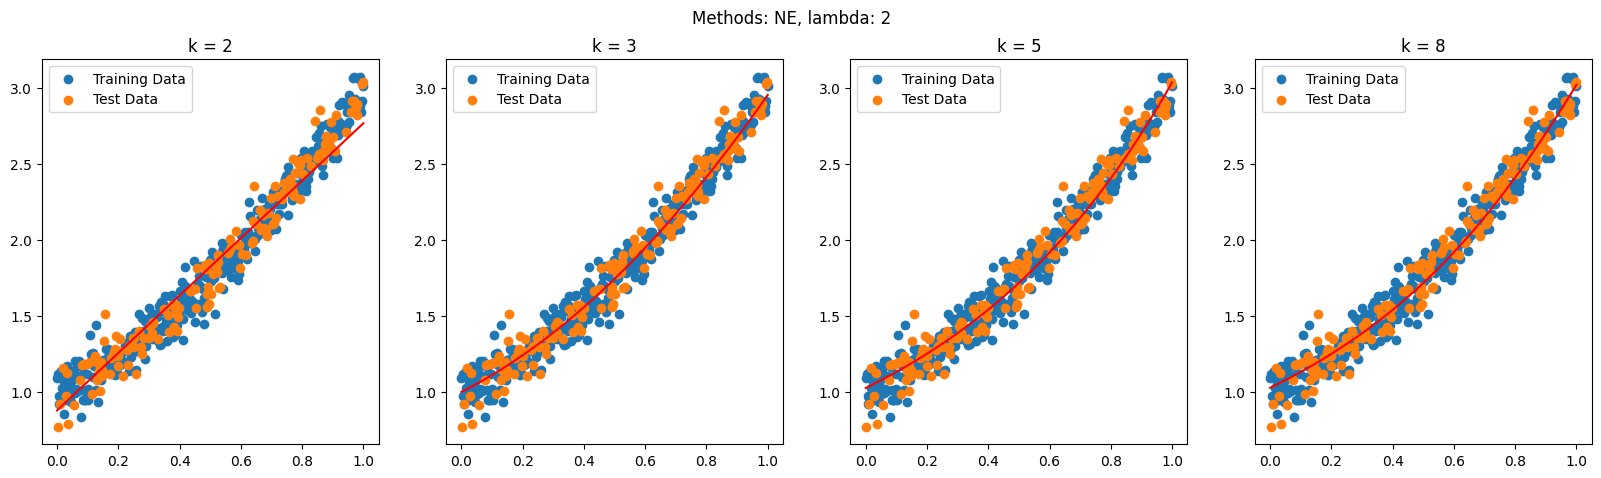

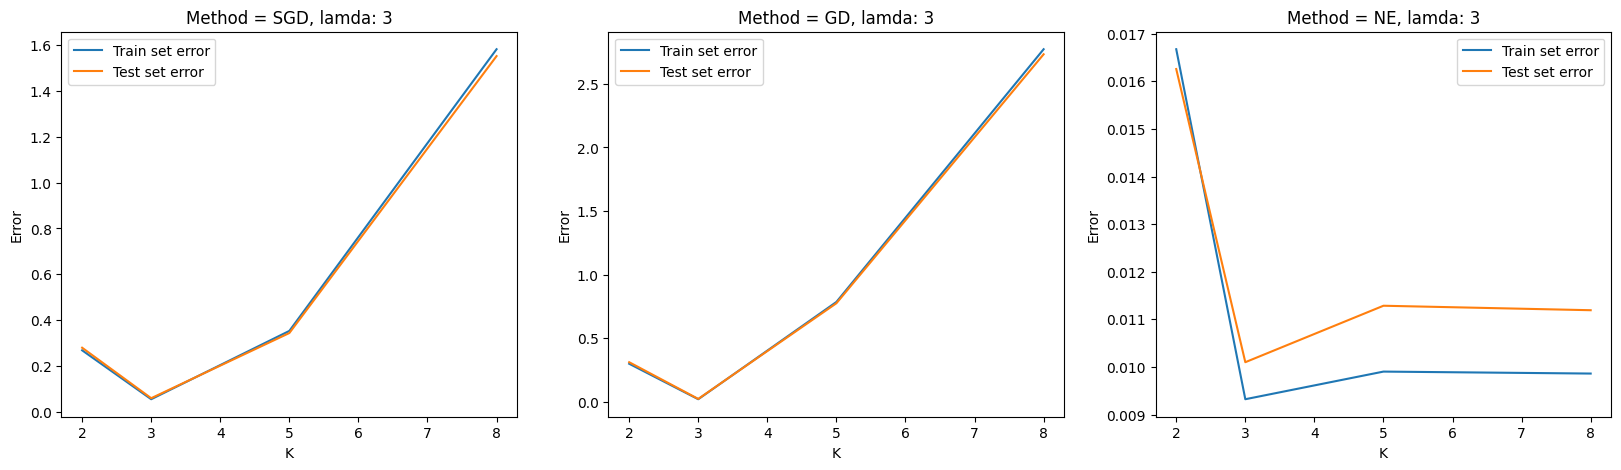

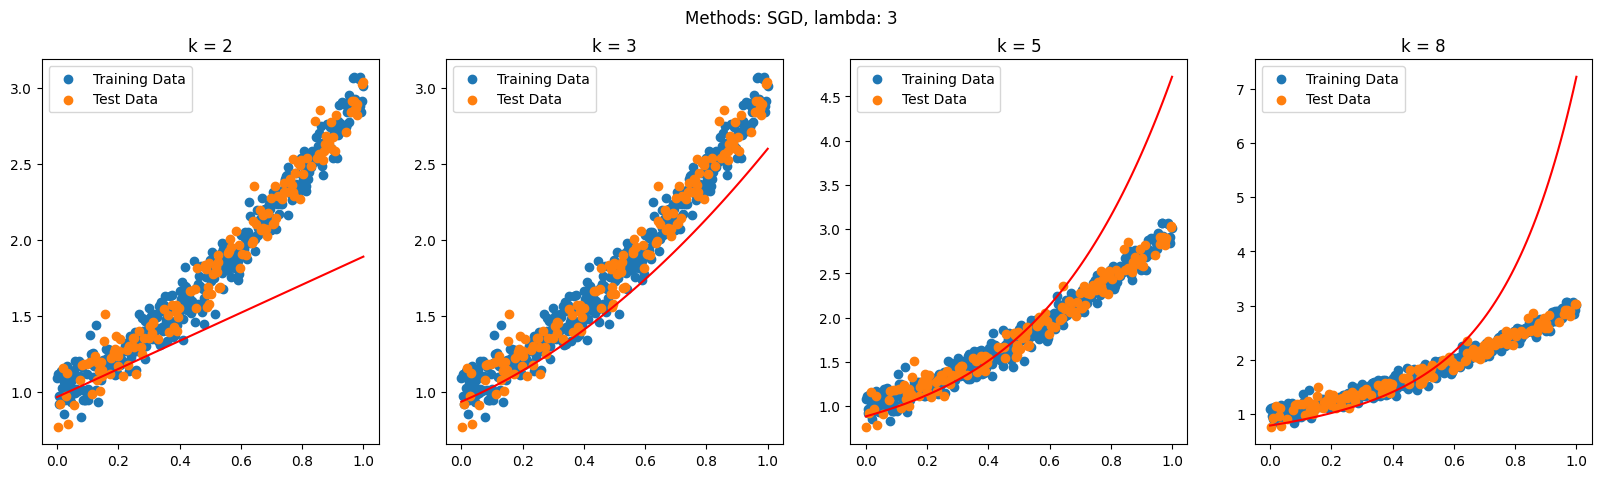

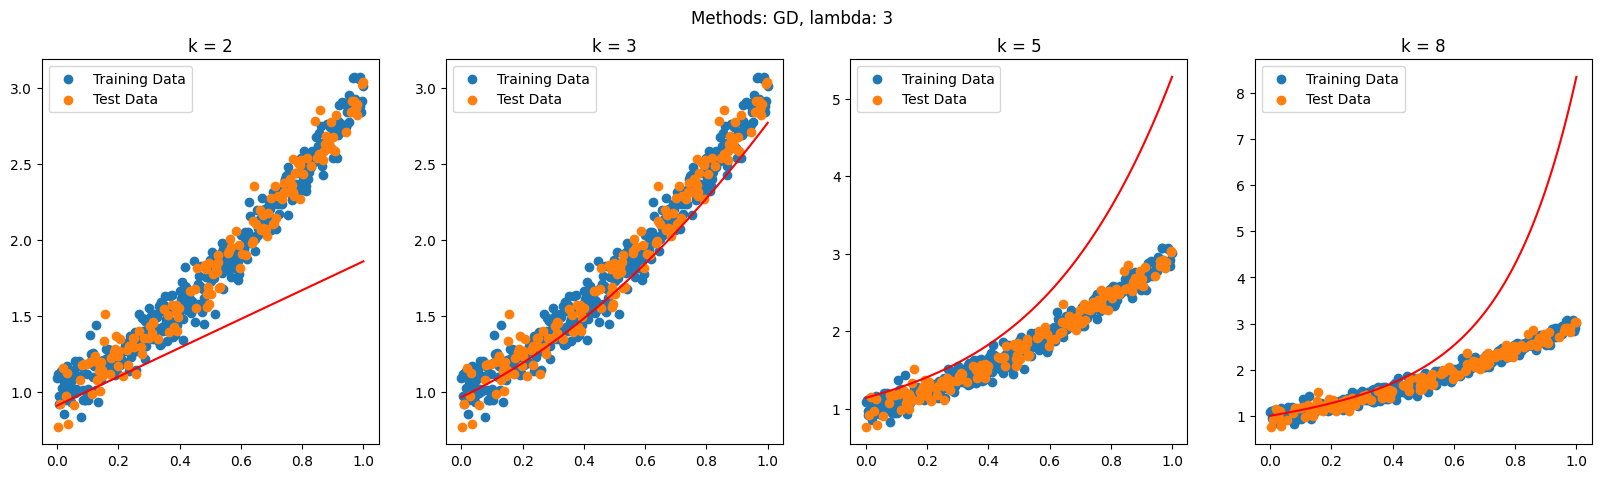

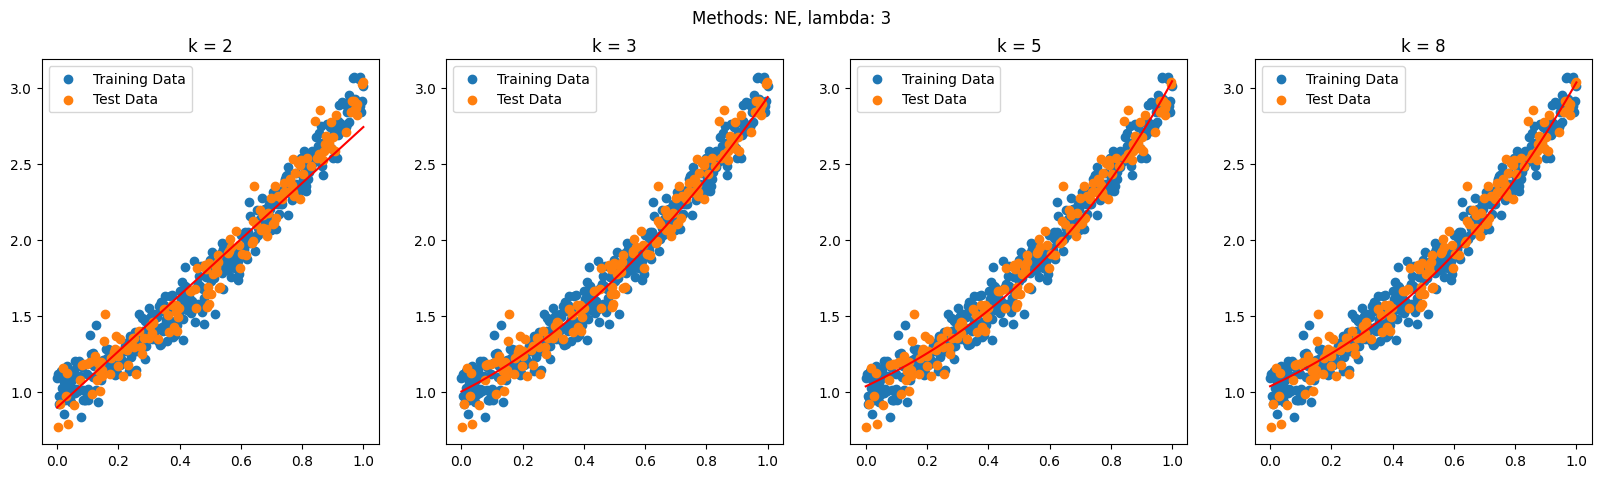

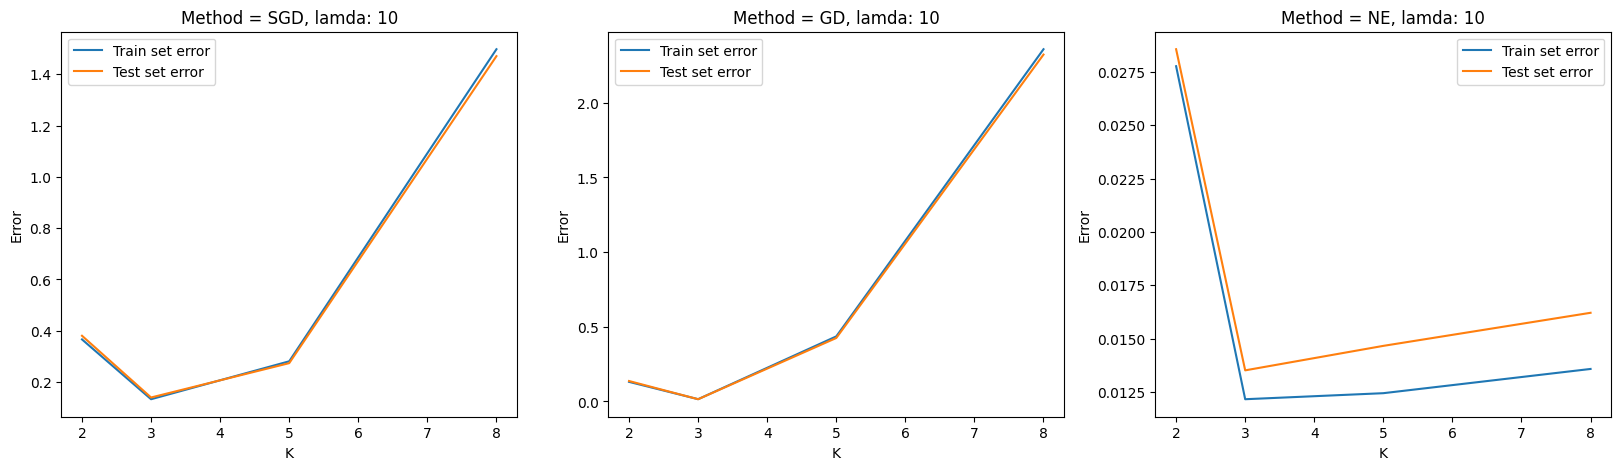

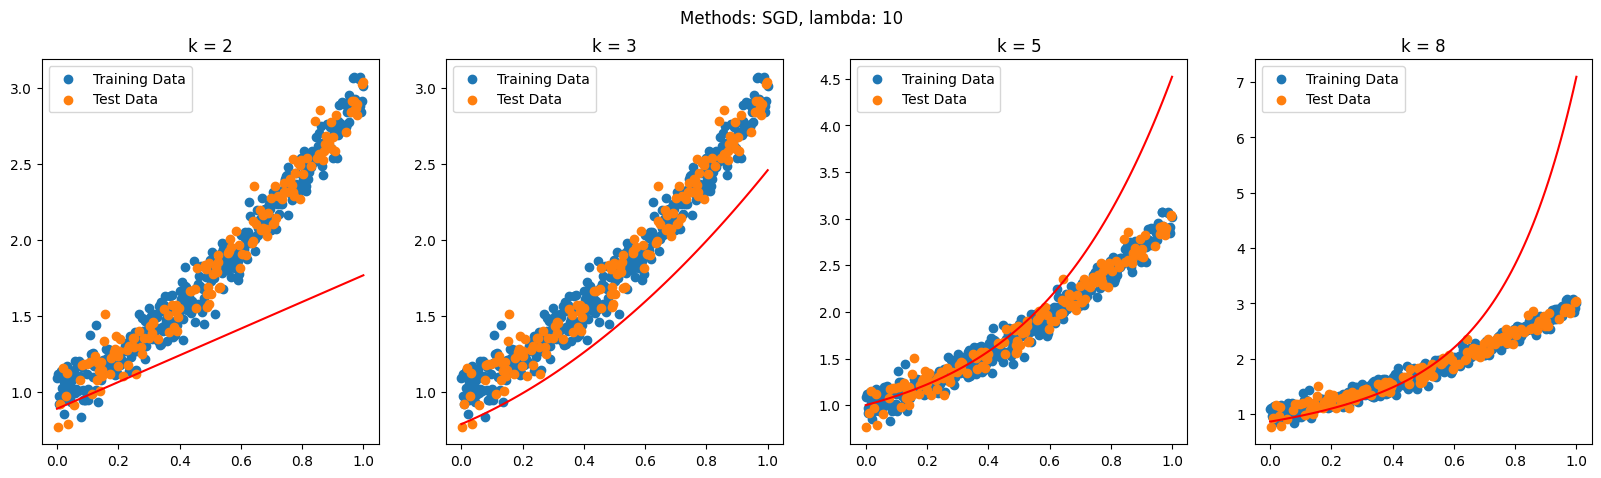

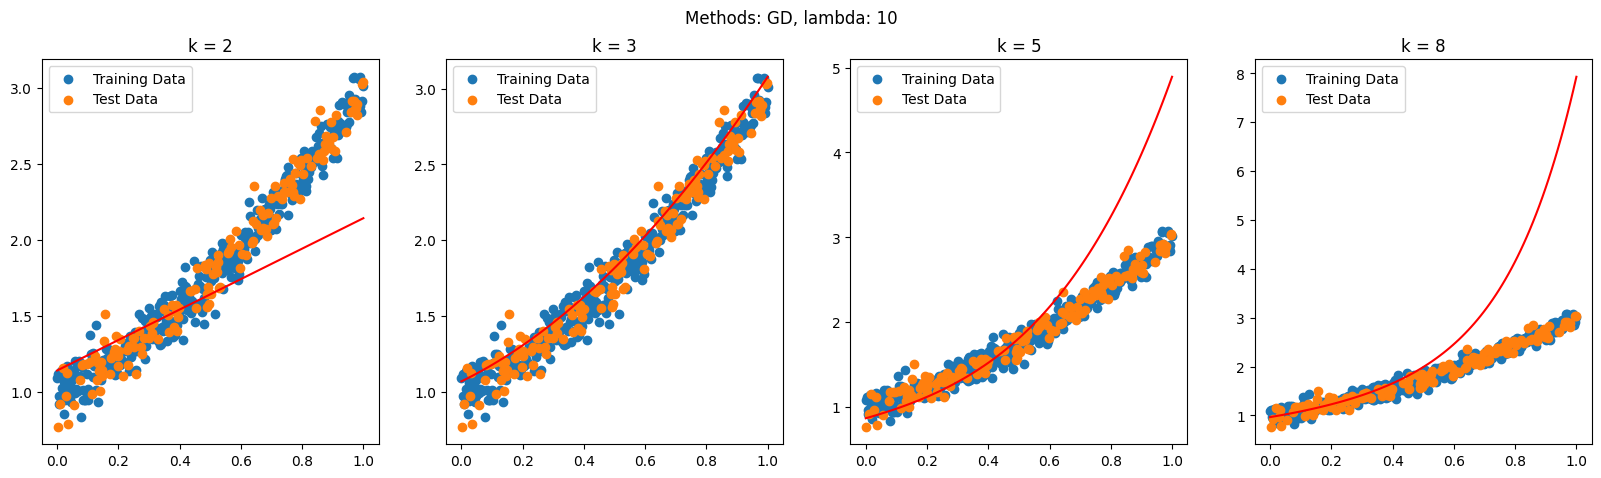

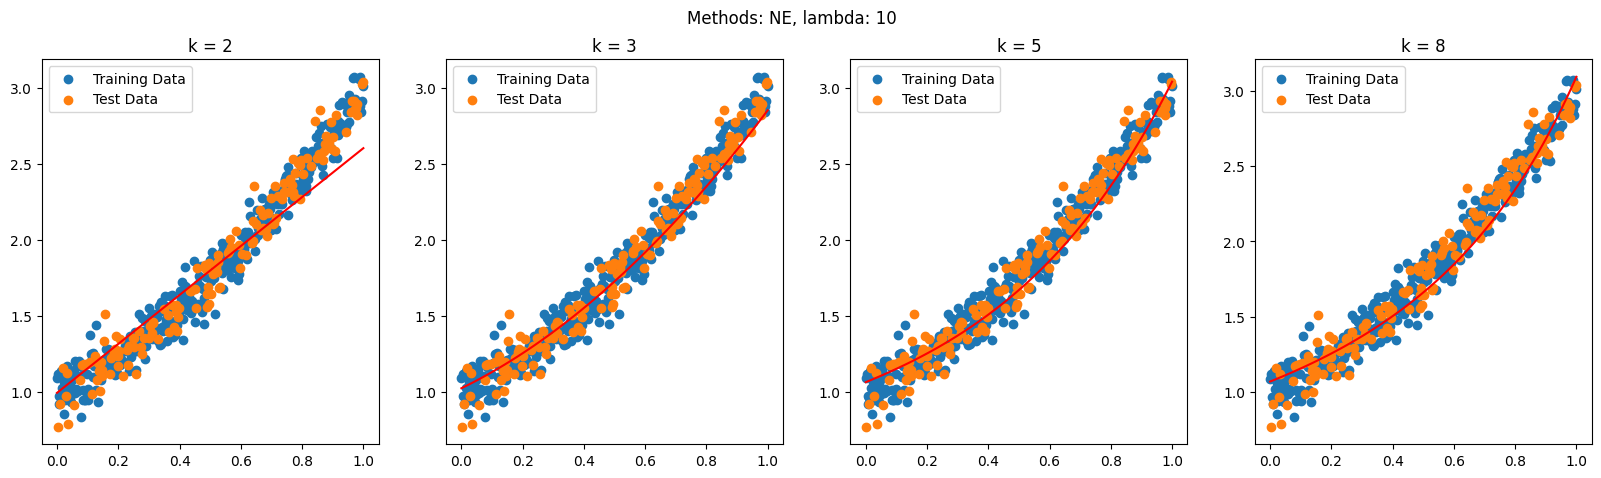

In [ ]:
ks = [2, 3, 5, 8]
methods = ["SGD", "GD","NE"]
lambs = [1, 2, 3, 10]

print("############################", end='\n\n')
print(f"     MAP, N={N}", end='\n\n')
print("############################", end='\n\n')

for lam in lambs:
  err_train_mle = {"SGD":[],"GD":[],"NE":[]}
  err_test_mle = {"SGD":[],"GD":[],"NE":[]}
  params = {"SGD":[],"GD":[],"NE":[]}
  plt.figure(figsize = (20, 5))
  for i, method in enumerate(methods):
    for k in ks:
      last_w = map_f((X_train, y_train), k, lam=lam, solver=method)
      params[method].append(last_w)
      err_train_mle[method].append(get_error((X_train, y_train), last_w))
      err_test_mle[method].append(get_error((X_test, y_test), last_w))

    plt.subplot(1, len(methods), i+1)
    plt.plot(ks, err_train_mle[method], label = "Train set error")
    plt.plot(ks, err_test_mle[method], label = "Test set error")
    plt.title(f"Method = {method}, lamda: {lam}")
    plt.xlabel("K")
    plt.ylabel("Error")
    plt.legend()

  for method in methods:
    plt.figure(figsize = (20, 5))
    plt.suptitle(f"Methods: {method}, lambda: {lam}")
    for i,k in enumerate(ks):
      x_f = np.linspace(a, b, 100)
      vander = create_vander(len(params[method][i]), x_f)
      y_f = vander @ params[method][i]

      plt.subplot(1, len(ks), i+1)
      plt.plot(x_f, y_f, color="red")
      plt.scatter(X_train, y_train, label="Training Data")
      plt.scatter(X_test, y_test, label = "Test Data")
      plt.title(f"k = {k}")
      plt.legend()